# electricity_market_player

> This module training optimizing and evaluation of RL agent on the electricity market environment.
using PPO with actions mask.

In [ ]:
# | default_exp electricity_market_player

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
from abc import ABC
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns
import torch
from rliable import library as rly
from rliable import metrics, plot_utils
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.evaluation import (
    evaluate_policy as maskable_evaluate_policy,
)
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from scipy import stats
from stable_baselines3 import A2C
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.evaluation import (
    evaluate_policy as non_maskable_evaluate_policy,
)
from stable_baselines3.common.monitor import Monitor
from tqdm.notebook import tqdm

from electricity_market.electricity_market_env import ElectricityMarketEnv, EnvConfig

In [ ]:
# | export
TOTAL_TIMESTEPS = 365 * 6 * 3
N_EPISODES = 10
N_TRAILS = 10
N_JOBS = -1
seeds = [123456, 234567, 345678]
number_of_frames = 10
frame_size = TOTAL_TIMESTEPS // number_of_frames
frames = np.array(list(range(frame_size, TOTAL_TIMESTEPS + 1, frame_size)), dtype=int)

env_config = EnvConfig(max_timestep=TOTAL_TIMESTEPS)
results = {}

In [ ]:
# | export


class Agent(ABC):
    def __init__(self):
        pass

    @classmethod
    def mask_fn(cls, env: ElectricityMarketEnv) -> np.ndarray:
        return env.action_masks()

    @classmethod
    def collect_episodes_rewards(
        cls,
        model: BaseAlgorithm | None,
        env: ElectricityMarketEnv,
        n_episodes: int = N_EPISODES,
        deterministic: bool = True,
        render: bool = False,
        seed: int | None = None,
    ) -> list[float]:
        raise NotImplementedError

    @classmethod
    def evaluate_policy(
        cls,
        hyperparameters: dict | None = None,
        n_episodes: int = N_EPISODES,
        render: bool = False,
    ) -> np.ndarray:
        raise NotImplementedError

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError

In [ ]:
# | export


class MaskableRandomAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
        cls,
        model: BaseAlgorithm | None,  # Unused for a random agent
        env: ElectricityMarketEnv,
        n_episodes: int = N_EPISODES,
        deterministic: bool = True,
        render: bool = False,
        seed: int | None = None,
    ) -> list[float]:
        episode_rewards = []

        for _ in range(n_episodes):
            obs, _ = env.reset(seed=seed)
            done = False
            total_reward = 0.0

            while not done:
                action_mask = env.action_masks()
                valid_actions = np.where(action_mask)[0]  # Get valid actions
                action = np.random.choice(valid_actions)  # Select random valid action

                obs, reward, done, truncated, _ = env.step(action)
                total_reward += reward
                if truncated:
                    break

            episode_rewards.append(total_reward)

        return episode_rewards

    @classmethod
    def evaluate_policy(
        cls,
        hyperparameters: dict | None = None,
        n_episodes: int = N_EPISODES,
        render: bool = False,
    ) -> np.ndarray:
        global seeds, frames, env_config

        all_rewards = []
        env = ActionMasker(
            ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn
        )
        for seed in tqdm(seeds, desc="seeds"):
            env.reset(seed=seed)
            seed_rewards = []

            for _ in tqdm(frames, desc="frames", leave=False):
                rewards = cls.collect_episodes_rewards(
                    None, env, n_episodes, deterministic=True, render=render, seed=seed
                )
                seed_rewards.append(rewards)
            seed_rewards = np.array(seed_rewards)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(
            all_rewards
        )  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print(
            "\nCollected Rewards (shape: seeds x checkpoints x episodes):\n",
            all_rewards,
        )

        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError

In [ ]:
# | export


class A2CAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
        cls,
        model: A2C,
        env: ElectricityMarketEnv,
        n_episodes: int = N_EPISODES,
        deterministic: bool = True,
        render: bool = False,
        seed: int | None = None,
    ) -> list[float]:
        env.reset(seed=seed)
        episode_rewards, _ = non_maskable_evaluate_policy(
            model,
            env,
            deterministic=deterministic,
            return_episode_rewards=True,
            n_eval_episodes=n_episodes,
            render=render,
        )
        return episode_rewards

    @classmethod
    def evaluate_policy(
        cls,
        hyperparameters: dict | None = None,
        n_episodes: int = N_EPISODES,
        render: bool = False,
    ) -> np.ndarray:
        global seeds, frames, env_config

        if hyperparameters is None:
            hyperparameters = {}
        all_rewards = []
        env = Monitor(
            ElectricityMarketEnv(env_config, render_mode="human"),
        )

        model = A2C(
            "MlpPolicy",
            env,
            verbose=0,
            **hyperparameters,
            tensorboard_log="./a2c_tensorboard/",
            device="cuda" if torch.cuda.is_available() else "cpu",
        )
        checkpoint_callback = CheckpointCallback(save_freq=10000, save_path="./logs/")
        for seed in tqdm(seeds, desc="seeds"):
            model.set_random_seed(seed)
            env.reset(seed=seed)
            seed_rewards = []

            for frame in tqdm(frames, desc="frames", leave=False):
                model.learn(
                    total_timesteps=frame,
                    reset_num_timesteps=False,
                    callback=checkpoint_callback,
                )
                rewards = cls.collect_episodes_rewards(
                    model,
                    env,
                    n_episodes=n_episodes,
                    deterministic=True,
                    render=render,
                    seed=seed,
                )
                seed_rewards.append(rewards)

            seed_rewards = np.array(
                seed_rewards
            )  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(
            all_rewards
        )  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print(
            "\nCollected Rewards (shape: seeds x checkpoints x episodes):\n",
            all_rewards,
        )
        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError

In [ ]:
# | export
class MaskablePPOAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
        cls,
        model: MaskablePPO,
        env: ElectricityMarketEnv,
        n_episodes: int = N_EPISODES,
        deterministic: bool = True,
        render: bool = False,
        seed: int | None = None,
    ) -> list[float]:
        env.reset(seed=seed)
        episode_rewards, _ = maskable_evaluate_policy(
            model,
            env,
            deterministic=deterministic,
            use_masking=True,
            return_episode_rewards=True,
            n_eval_episodes=n_episodes,
            render=render,
        )
        return episode_rewards

    @classmethod
    def evaluate_policy(
        cls,
        hyperparameters: dict | None = None,
        n_episodes: int = N_EPISODES,
        render: bool = False,
    ) -> np.ndarray:
        global seeds, frames, env_config

        if hyperparameters is None:
            hyperparameters = {}
        all_rewards = []

        env = Monitor(
            ActionMasker(
                ElectricityMarketEnv(env_config, render_mode="human"),
                cls.mask_fn,
            )
        )

        model = MaskablePPO(
            MaskableActorCriticPolicy,
            env,
            verbose=0,
            **hyperparameters,
            tensorboard_log="./maskable_ppo_tensorboard/",
            device="cuda" if torch.cuda.is_available() else "cpu",
        )
        checkpoint_callback = CheckpointCallback(save_freq=10000, save_path="./logs/")
        for seed in tqdm(seeds, desc="seeds"):
            model.set_random_seed(seed)
            env.reset(seed=seed)
            seed_rewards = []
            for frame in tqdm(frames, desc="frames", leave=False):
                model.learn(
                    total_timesteps=frame,
                    use_masking=True,
                    reset_num_timesteps=False,
                    callback=checkpoint_callback,
                )
                rewards = cls.collect_episodes_rewards(
                    model,
                    env,
                    n_episodes=n_episodes,
                    deterministic=True,
                    render=render,
                    seed=seed,
                )
                seed_rewards.append(rewards)

            seed_rewards = np.array(
                seed_rewards
            )  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(
            all_rewards
        )  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print(
            "\nCollected Rewards (shape: seeds x checkpoints x episodes):\n",
            all_rewards,
        )
        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        global seeds
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        n_steps = trial.suggest_int("n_steps", 32, 1024, log=True)
        batch_size = trial.suggest_int("batch_size", 16, 256, log=True)
        gamma = trial.suggest_float("gamma", 0.9, 0.9999)
        gae_lambda = trial.suggest_float("gae_lambda", 0.8, 1.0)
        ent_coef = trial.suggest_float("ent_coef", 0.0, 0.02)
        vf_coef = trial.suggest_float("vf_coef", 0.1, 1.0)
        clip_range = trial.suggest_float("clip_range", 0.1, 0.3)
        max_grad_norm = trial.suggest_float("max_grad_norm", 0.1, 1.0)

        trial_seed_rewards = []
        env = Monitor(
            ActionMasker(
                ElectricityMarketEnv(env_config, render_mode="human"),
                maskable_ppo_agent.mask_fn,
            )
        )
        model = MaskablePPO(
            MaskableActorCriticPolicy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            batch_size=batch_size,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            clip_range=clip_range,
            max_grad_norm=max_grad_norm,
            verbose=0,
            tensorboard_log="./maskable_ppo_tensorboard/",
            device="cuda" if torch.cuda.is_available() else "cpu",
        )
        checkpoint_callback = CheckpointCallback(save_freq=10000, save_path="./logs/")

        for seed in tqdm(seeds, desc="seeds"):
            model.set_random_seed(seed)
            env.reset(seed=seed)
            model.learn(
                total_timesteps=TOTAL_TIMESTEPS,
                use_masking=True,
                callback=checkpoint_callback,
            )
            episode_rewards = cls.collect_episodes_rewards(
                model,
                env,
                n_episodes=n_episodes,
                deterministic=True,
                render=False,
                seed=seed,
            )

            seed_avg_reward = np.mean(episode_rewards)
            trial_seed_rewards.append(seed_avg_reward)
        aggregated_performance = stats.trim_mean(
            trial_seed_rewards, proportiontocut=0.25
        )

        return aggregated_performance

In [ ]:
# | export
# Function to compute aggregated metrics for each algorithm


def aggregate_func(x):
    return np.array(
        [
            metrics.aggregate_median(x),
            metrics.aggregate_iqm(x),
            metrics.aggregate_mean(x),
        ],
        dtype=np.float64,
    )


# Aggregate results across seeds and episodes for each algorithm


def aggregate_over_checkpoints(evaluation_results):
    aggregated_results = {}
    for algorithm, results in evaluation_results.items():
        # results.shape is (num_seeds, num_checkpoints, num_episodes)
        # We aggregate across seeds and episodes for each checkpoint
        agg_results = np.array(
            [aggregate_func(results[:, i, :]) for i in range(results.shape[1])]
        )
        aggregated_results[algorithm] = agg_results
    return aggregated_results


# Function to plot aggregate metrics (Median, IQM, Mean)


def plot_aggregate_metrics(aggregated_results, algorithms):
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        aggregated_results, aggregate_func, reps=50000
    )

    metric_names = ["Median", "IQM", "Mean"]
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=metric_names,
        algorithms=algorithms,
        xlabel="Reward",
    )
    fig.set_size_inches(10, 5)
    plt.suptitle(
        "Aggregate Metrics with 95% Stratified Bootstrap CIs", y=1.05, fontsize=16
    )
    plt.xticks(rotation=45, fontsize=12)
    plt.show()


# Function to plot the probability of improvement between two algorithms


def plot_probability_of_improvement(evaluation_results, algorithms):
    for alg1, alg2 in combinations(algorithms, 2):
        algorithm_pairs = {
            f"{alg1},{alg2}": (evaluation_results[alg1], evaluation_results[alg2])
        }

        average_probabilities, average_prob_cis = rly.get_interval_estimates(
            algorithm_pairs, metrics.probability_of_improvement, reps=2000
        )

        plot_utils.plot_probability_of_improvement(
            average_probabilities, average_prob_cis
        )
        plt.title(f"Probability of Improvement: {alg1} vs {alg2}", pad=20)
        plt.show()


# Function to plot the sample efficiency curve


def plot_sample_efficiency_curve(evaluation_results, frames):
    global number_of_frames
    sample_efficiency_dict = {
        alg: results[:, :, :]
        for alg, results in evaluation_results.items()
        if len(results.shape) == 3
    }

    iqm_func = lambda scores: np.array(
        [
            metrics.aggregate_iqm(scores[:, :, frame])
            for frame in range(number_of_frames)
        ]
    )
    iqm_scores, iqm_cis = rly.get_interval_estimates(
        sample_efficiency_dict, iqm_func, reps=50000
    )

    plot_utils.plot_sample_efficiency_curve(
        frames=frames + 1,  # Adjust frames if necessary
        point_estimates=iqm_scores,
        interval_estimates=iqm_cis,
        algorithms=sample_efficiency_dict.keys(),
        xlabel="Number of Frames",
        ylabel="IQM Reward",
    )
    plt.title("Sample Efficiency Curve")
    plt.show()


# Function to plot performance profiles (linear and non-linear scaling)


def plot_performance_profiles(evaluation_results, algorithms):
    thresholds = np.linspace(0.0, 8.0, 81)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        evaluation_results, thresholds
    )

    # Plot performance profiles with linear scale
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        colors=dict(zip(algorithms, sns.color_palette("colorblind"))),
        xlabel=r"Normalized Score $(\tau)$",
        ax=ax,
    )
    plt.title("Performance Profiles (Linear Scale)")
    plt.show()

    # Plot performance profiles with non-linear scaling
    thresholds = np.logspace(-1, 0, num=50)
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        use_non_linear_scaling=True,
        colors=dict(zip(algorithms, sns.color_palette("colorblind"))),
        xlabel=r"Normalized Score $(\tau)$",
        ax=ax,
    )
    plt.title("Performance Profiles (Non-Linear Scaling)")
    plt.tight_layout()
    plt.show()


def plot_learning_curves(evaluation_results, algorithms):
    """Plots learning curves over training timesteps for multiple algorithms."""
    global frames
    plt.figure(figsize=(12, 8))

    # Convert frames (checkpoints) to cumulative timesteps
    total_timesteps = frames  # X-axis: total timesteps

    for algorithm in algorithms:
        rewards = evaluation_results[algorithm]  # Shape: (seeds, checkpoints, episodes)

        # Mean reward per checkpoint (average over seeds and episodes)
        mean_rewards_per_checkpoint = np.mean(rewards, axis=(0, 2))
        std_rewards_per_checkpoint = np.std(rewards, axis=(0, 2))

        plt.plot(
            total_timesteps,
            mean_rewards_per_checkpoint,
            label=algorithm,
            marker="o",
            linestyle="-",
        )
        plt.fill_between(
            total_timesteps,
            mean_rewards_per_checkpoint - std_rewards_per_checkpoint,
            mean_rewards_per_checkpoint + std_rewards_per_checkpoint,
            alpha=0.2,
        )

    plt.xlabel("Total Timesteps", fontsize=14)
    plt.ylabel("Mean Episode Reward", fontsize=14)
    plt.title("Learning Curves Over Training Timesteps", fontsize=16, fontweight="bold")

    plt.legend(loc="best", fontsize=12, title="Algorithms")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout(pad=2.0)
    plt.show()


# Main function to call all the individual plot functions


def plot_evaluation_results(evaluation_results: dict) -> None:
    global frames
    algorithms = list(evaluation_results.keys())

    # Plot Learning Curves
    plot_learning_curves(evaluation_results, algorithms)

    # Aggregate the results across seeds and checkpoints
    aggregated_results = aggregate_over_checkpoints(evaluation_results)

    # Plot aggregate metrics
    plot_aggregate_metrics(aggregated_results, algorithms)

    # Plot Probability of Improvement
    plot_probability_of_improvement(evaluation_results, algorithms)

    # Plot Sample Efficiency Curve
    plot_sample_efficiency_curve(evaluation_results, frames)

    # Plot Performance Profiles
    plot_performance_profiles(evaluation_results, algorithms)

In [ ]:
# | export
a2c_agent = A2CAgent()
maskable_random_agent = MaskableRandomAgent()
maskable_ppo_agent = MaskablePPOAgent()

### Evaluation A2C on ElectricityMarketEnv


In [ ]:
# | export
results["A2CAgent"] = a2c_agent.evaluate_policy(
    hyperparameters=None, n_episodes=N_EPISODES, render=False
)

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-5.27655701e+03 -5.24769210e+03 -5.23570407e+03 -5.25051549e+03
   -5.27322970e+03 -5.29385278e+03 -5.18504088e+03 -5.29348167e+03
   -5.27448113e+03 -5.25768664e+03]
  [-6.57100000e+03 -6.57100000e+03 -6.57100000e+03 -6.57100000e+03
   -6.57100000e+03 -6.57100000e+03 -6.57100000e+03 -6.57100000e+03
   -6.57100000e+03 -6.57100000e+03]
  [-6.56582655e+03 -6.56696444e+03 -6.56685837e+03 -6.56806888e+03
   -6.56709936e+03 -6.56684635e+03 -6.56809865e+03 -6.56607941e+03
   -6.56711141e+03 -6.56692085e+03]
  [-3.07611962e+03 -3.07973830e+03 -3.13605497e+03 -3.20542037e+03
   -3.05614533e+03 -3.02368125e+03 -3.12584220e+03 -3.16592122e+03
   -3.17505928e+03 -3.12419885e+03]
  [-5.14837567e+02 -6.08628072e+02 -6.43140065e+02 -6.03293873e+02
   -5.76528729e+02 -5.44096891e+02 -6.54288586e+02 -6.65770824e+02
   -5.67924322e+02 -6.05323798e+02]
  [-1.18580189e+03 -1.24685685e+03 -1.25093840e+03 -1.19743525e+03
   -1.25124475e+03 -1.

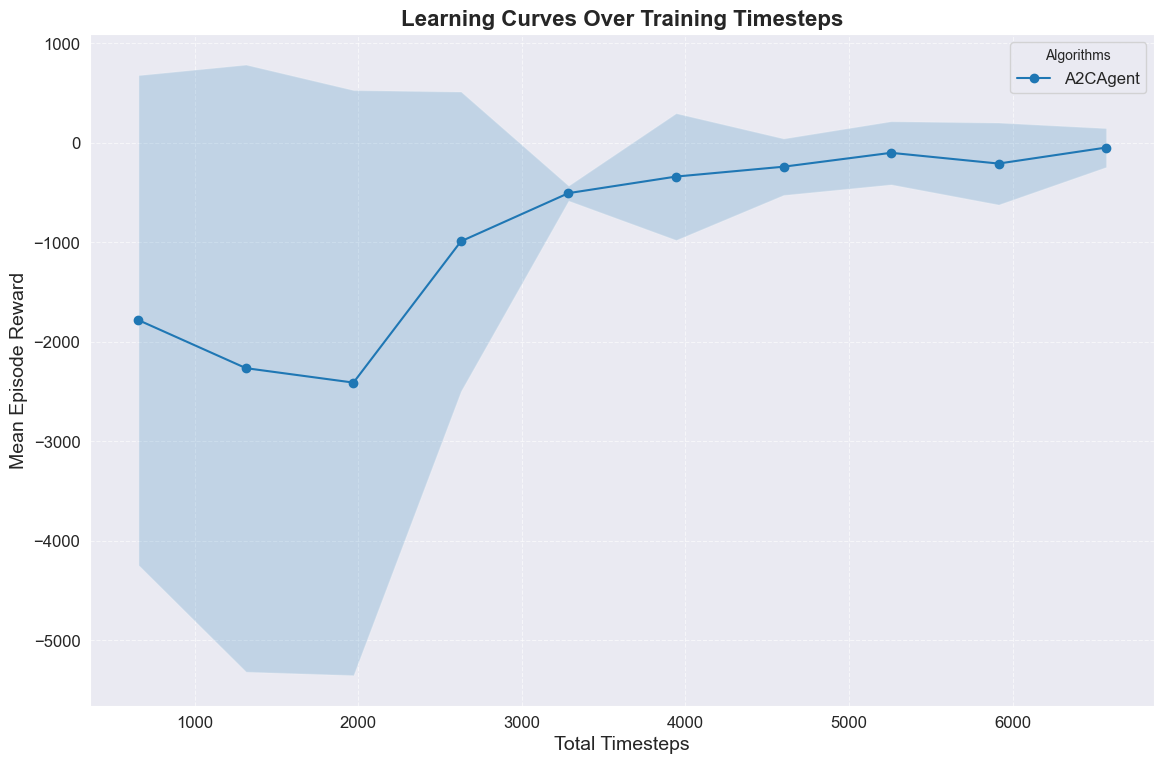

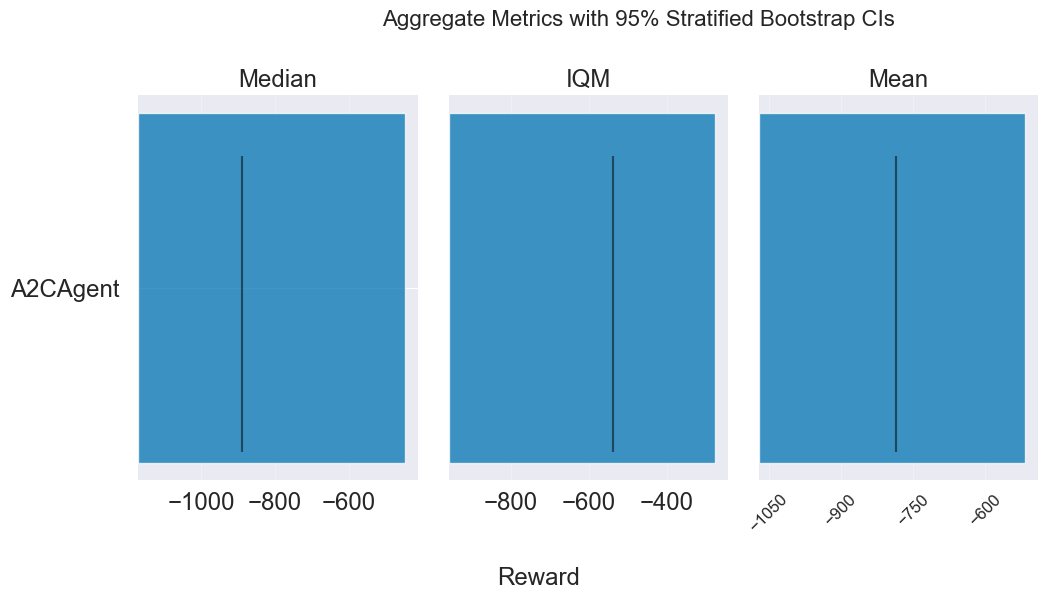

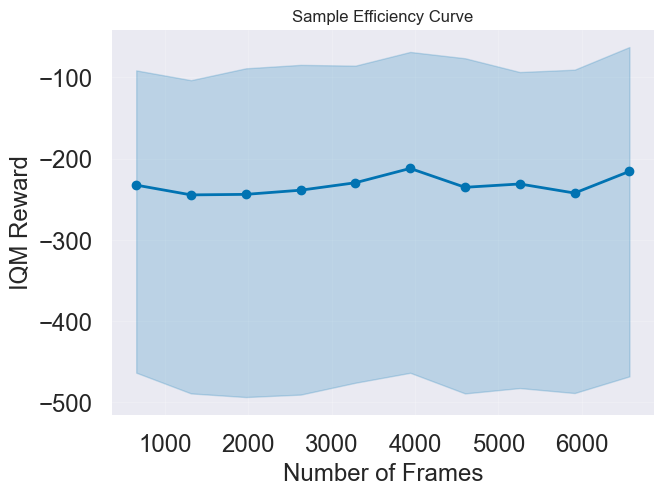

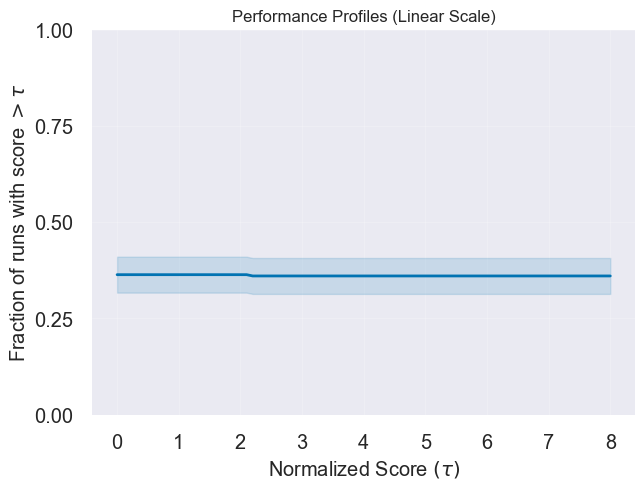

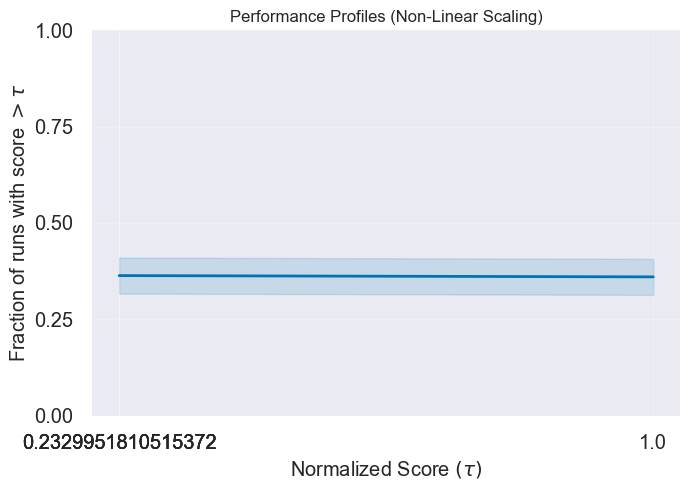

In [ ]:
# | export
plot_evaluation_results(results)

### Evaluation MaskableRandom on ElectricityMarketEnv


In [ ]:
# | export
results["MaskableRandomAgent"] = maskable_random_agent.evaluate_policy(
    hyperparameters=None, n_episodes=N_EPISODES, render=False
)

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254
   -675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254]
  [-675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254
   -675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254]
  [-675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254
   -675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254]
  [-675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254
   -675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254]
  [-675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254
   -675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254]
  [-675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254
   -675.71810254 -675.71810254 -675.71810254 -675.71810254 -675.71810254]
  [-675.71810254 -675.71810254 -675.71810254 -675.7181025

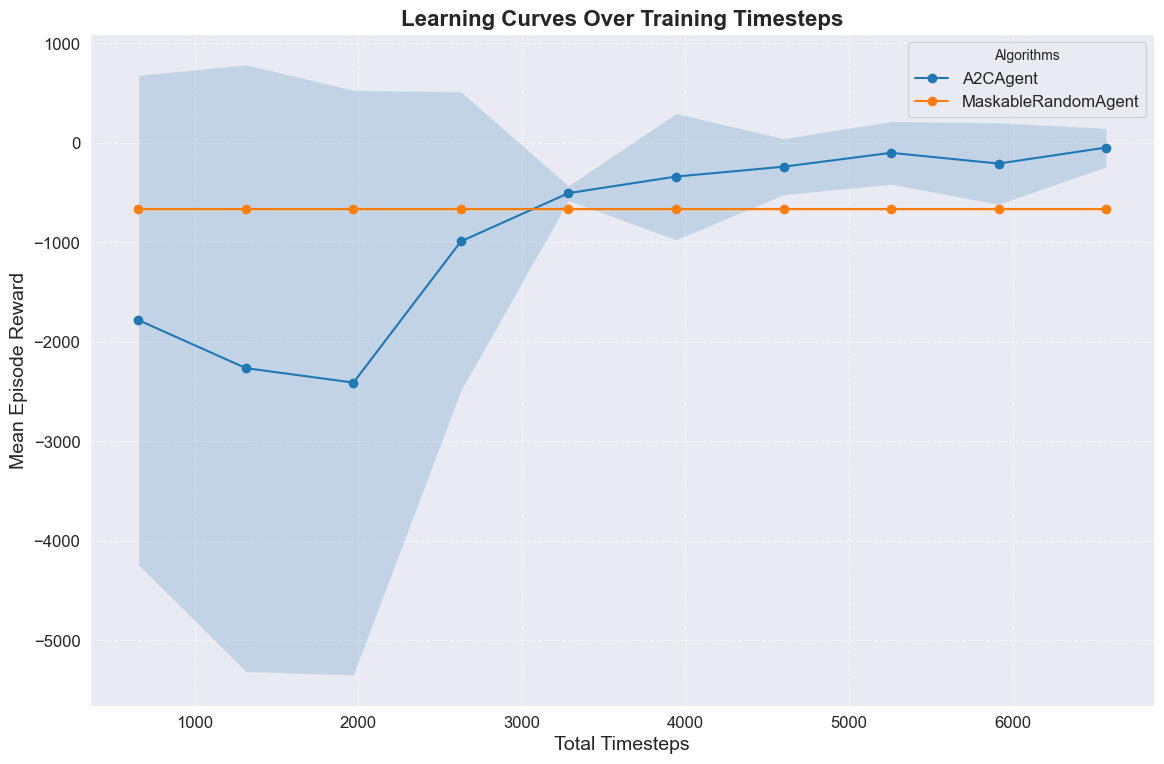

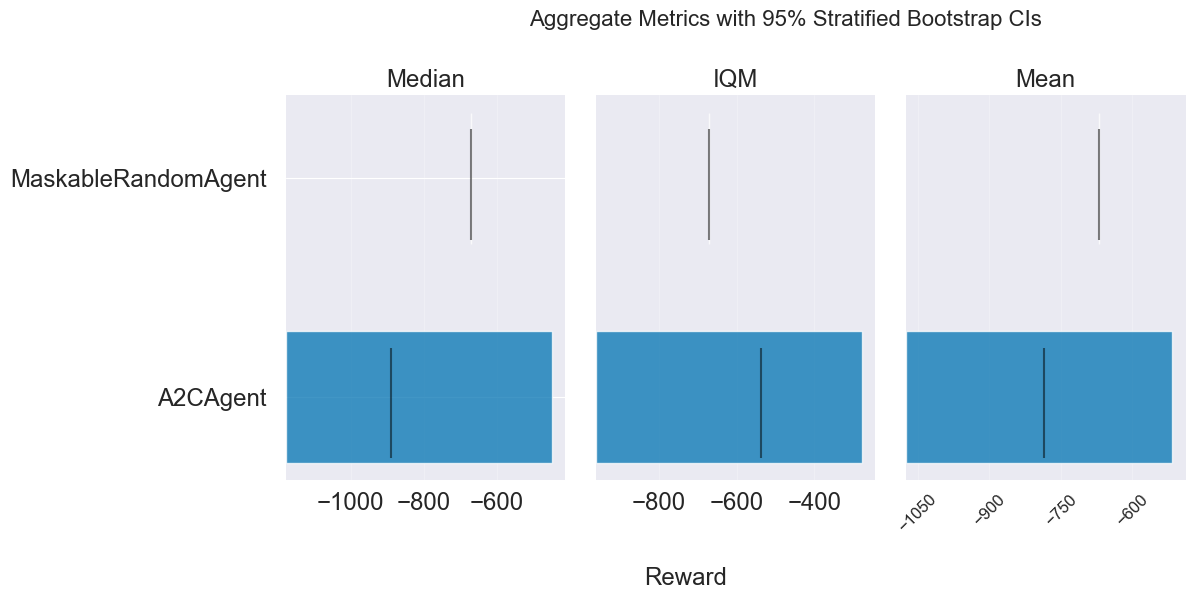

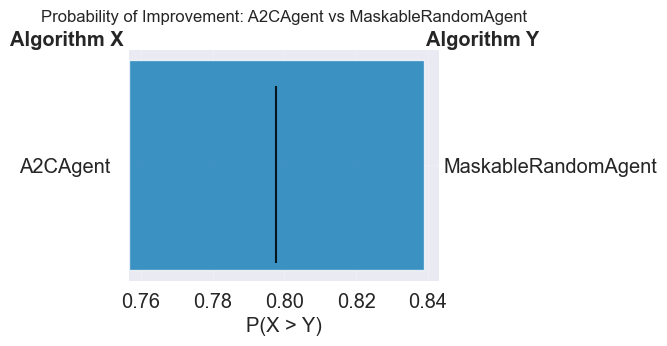

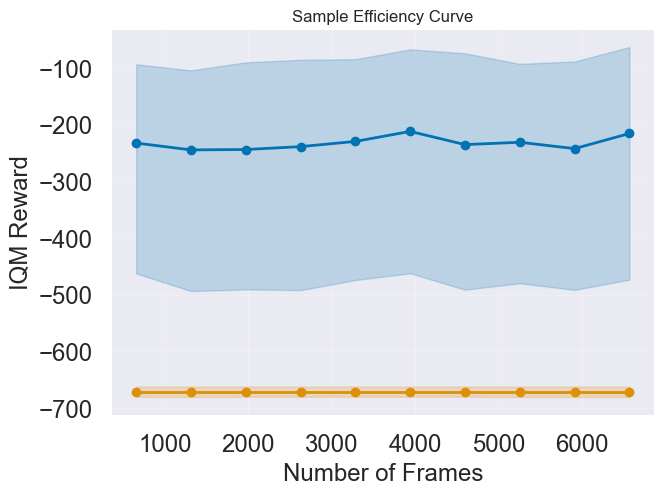

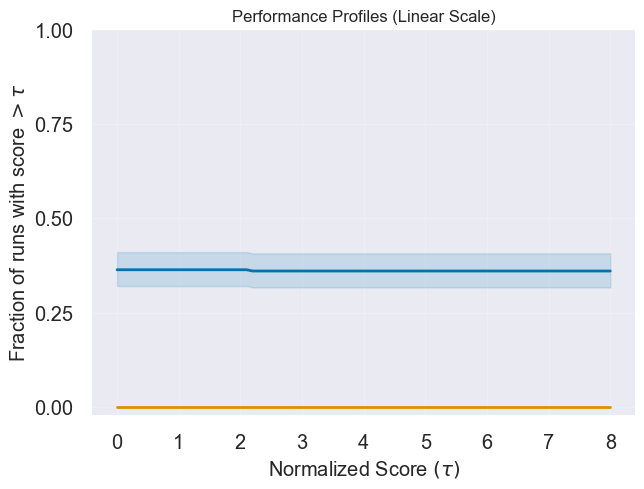

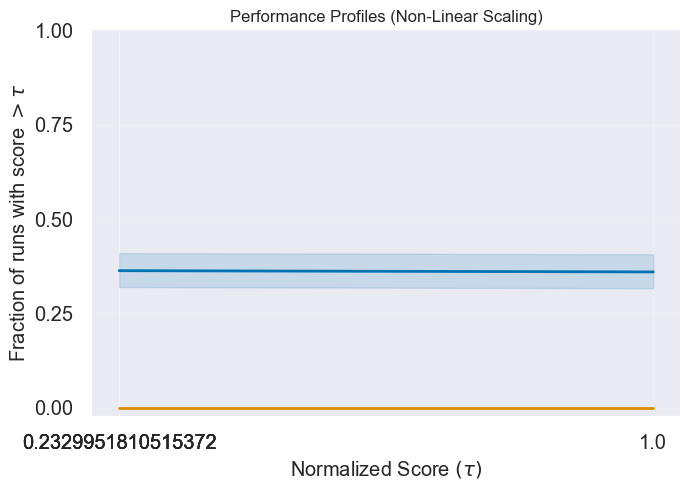

In [ ]:
# | export
plot_evaluation_results(results)

### Evaluation MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
# | export
results["MaskablePPOAgent_Baseline"] = maskable_ppo_agent.evaluate_policy(
    hyperparameters=None, n_episodes=N_EPISODES, render=False
)

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-700.564863 -724.139074 -698.405806 -702.695582 -705.85681
   -702.539843 -699.758927 -685.898825 -690.87855  -714.40782 ]
  [-680.673016 -686.230095 -678.971511 -691.310584 -690.406883
   -688.570044 -672.303803 -686.841835 -693.567227 -682.982769]
  [-422.616347 -404.474328 -414.86973  -433.957953 -435.574062
   -425.897286 -431.193983 -407.648232 -425.087264 -434.198834]
  [-471.848334 -504.352114 -472.935733 -479.870906 -483.637519
   -478.973116 -505.889284 -512.032859 -492.646613 -463.833884]
  [-463.974903 -461.680322 -444.841088 -461.270089 -464.181439
   -465.710205 -469.289549 -469.138441 -505.720516 -460.298439]
  [-388.991482 -385.494376 -383.69996  -373.652353 -405.279801
   -404.754127 -399.894168 -378.688865 -417.892241 -398.776225]
  [-144.658545 -165.503096 -133.331461 -132.830623 -140.283572
   -129.746335 -159.565561 -135.256914 -157.104349 -144.94035 ]
  [ -91.077187 -106.175653 -106.533003  -87.347699 

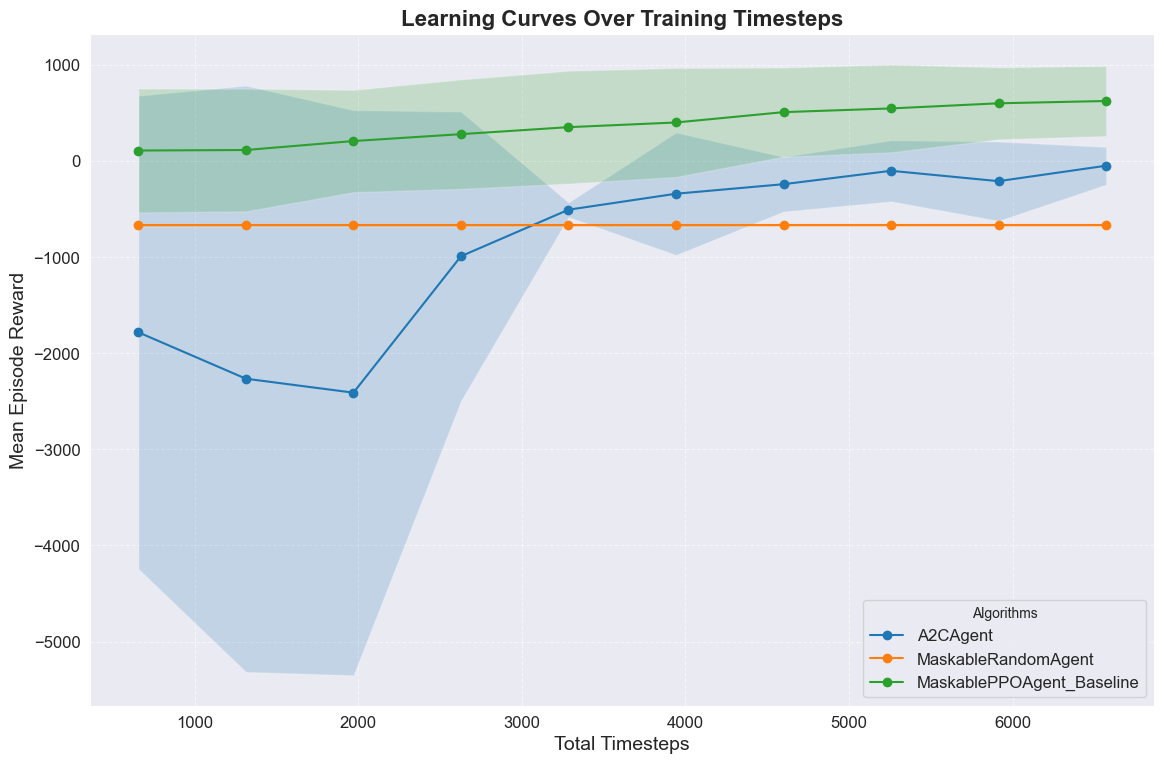

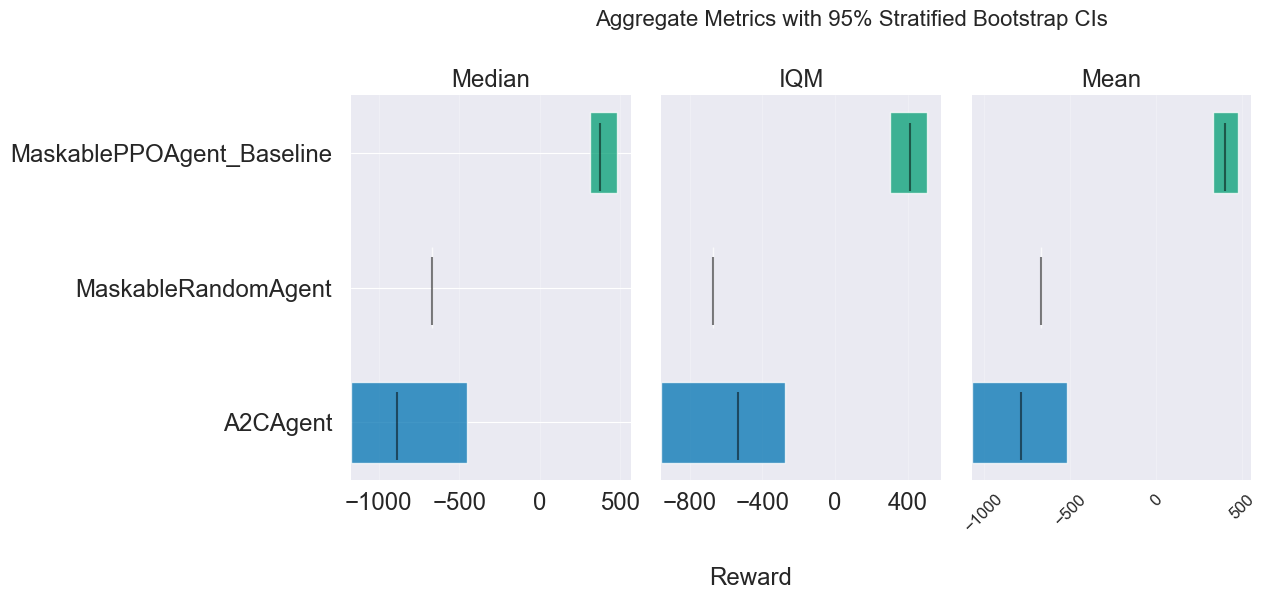

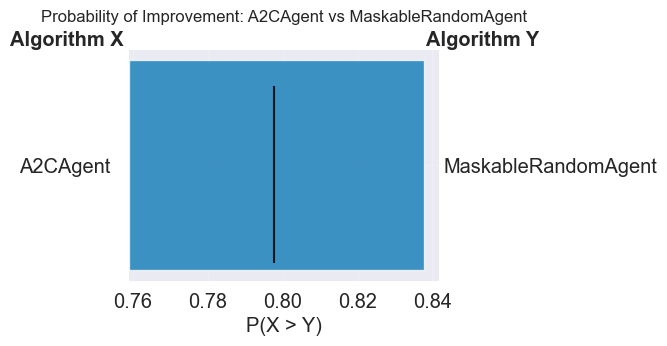

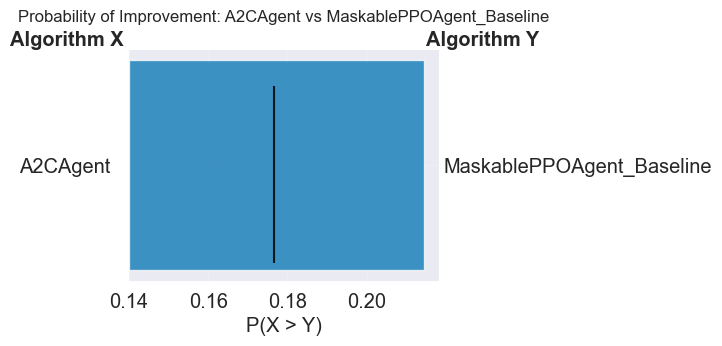

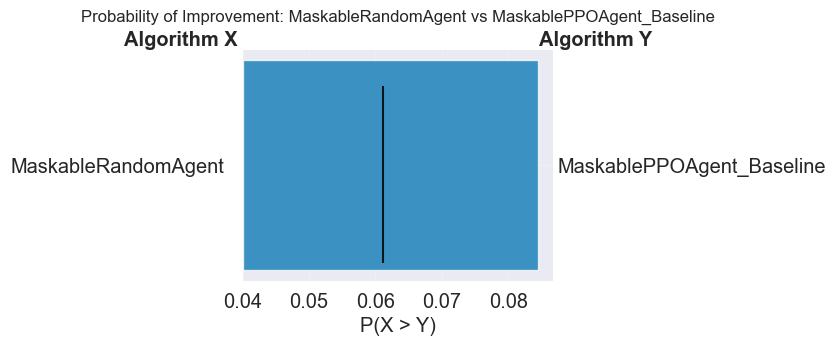

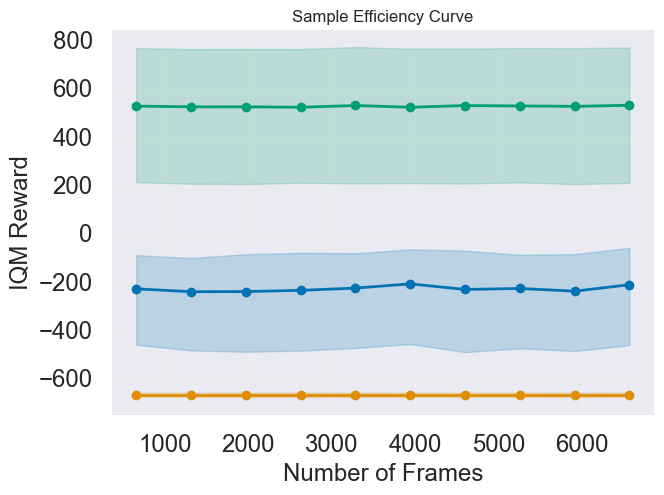

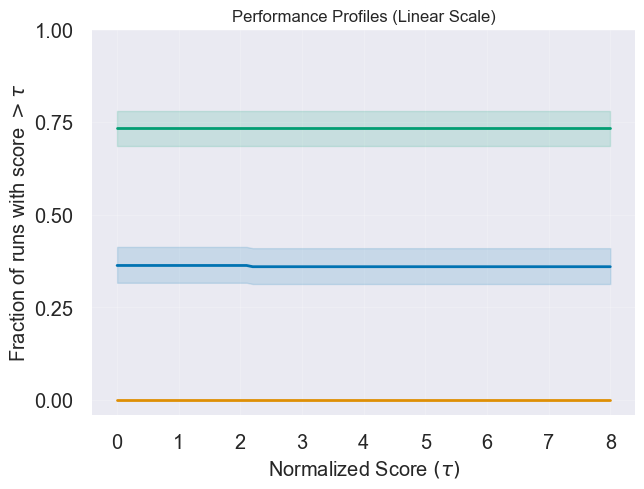

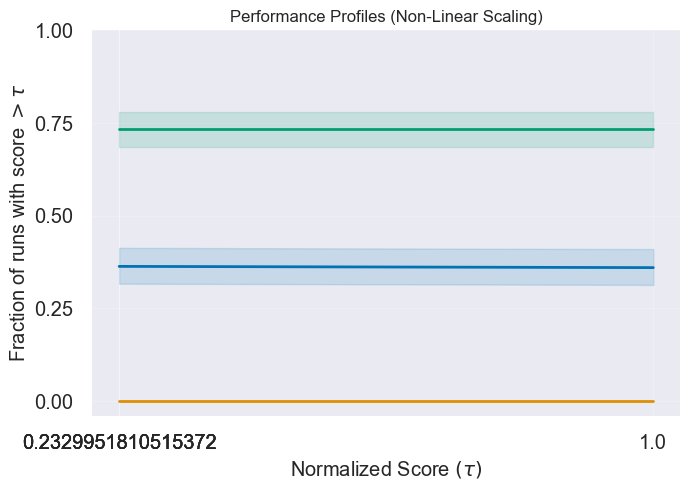

In [ ]:
# | export
plot_evaluation_results(results)

### Hypertuning MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
# | export
study = optuna.create_study(
    study_name="maskable_ppo_hypertuning",
    storage="sqlite:///optuna_study.db",
    load_if_exists=True,
    direction="maximize",
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(
    maskable_ppo_agent.optimize_agent,
    n_trials=N_TRAILS,
    n_jobs=N_JOBS,
    show_progress_bar=True,
)

print("Best trial:", study.best_trial)

[I 2025-02-22 21:30:53,025] Using an existing study with name 'maskable_ppo_hypertuning' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-22 21:44:43,557] Trial 23 finished with value: -781.4429609333333 and parameters: {'learning_rate': 6.193926191072163e-05, 'n_steps': 60, 'batch_size': 28, 'gamma': 0.9983727083044408, 'gae_lambda': 0.8094223251085811, 'ent_coef': 0.01999337945249826, 'vf_coef': 0.9957338228100456, 'clip_range': 0.2107187992519836, 'max_grad_norm': 0.8816587459717282}. Best is trial 8 with value: -6.310616166666667.


seeds:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-22 21:46:25,196] Trial 25 finished with value: -728.8477327999999 and parameters: {'learning_rate': 5.801063149115669e-05, 'n_steps': 66, 'batch_size': 19, 'gamma': 0.9005949713815391, 'gae_lambda': 0.8098513359104058, 'ent_coef': 0.019492624788758475, 'vf_coef': 0.9649086245016213, 'clip_range': 0.2118672897750779, 'max_grad_norm': 0.9295273622673297}. Best is trial 8 with value: -6.310616166666667.


seeds:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-22 21:46:38,465] Trial 20 finished with value: -504.44162766666665 and parameters: {'learning_rate': 6.347818834527872e-05, 'n_steps': 46, 'batch_size': 23, 'gamma': 0.9003379498309232, 'gae_lambda': 0.8091481698197889, 'ent_coef': 0.019523217003599613, 'vf_coef': 0.6047646510516642, 'clip_range': 0.21367217713063158, 'max_grad_norm': 0.9140206885430089}. Best is trial 8 with value: -6.310616166666667.
[I 2025-02-22 21:46:46,006] Trial 18 finished with value: -653.8424692666666 and parameters: {'learning_rate': 6.461385366844159e-05, 'n_steps': 71, 'batch_size': 18, 'gamma': 0.9001551602863199, 'gae_lambda': 0.8028020166013662, 'ent_coef': 0.01949004332678888, 'vf_coef': 0.5457425249710705, 'clip_range': 0.21994281008383257, 'max_grad_norm': 0.9311468518193731}. Best is trial 8 with value: -6.310616166666667.
[I 2025-02-22 21:46:56,157] Trial 22 finished with value: -712.9505551666667 and parameters: {'learning_rate': 6.476255265541494e-05, 'n_steps': 60, 'batch_size': 17, '

### Evaluation MaskablePPO with optimized hyperparameters on ElectricityMarketEnv

In [ ]:
# | export
results["MaskablePPOAgent_Optimized"] = maskable_ppo_agent.evaluate_policy(
    hyperparameters=study.best_trial.params, n_episodes=N_EPISODES, render=False
)

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-882.221453 -878.230902 -874.357964 -885.77796  -863.666031
   -876.561405 -877.356972 -873.521956 -874.626251 -868.971282]
  [-863.667333 -852.000952 -860.142694 -842.486683 -852.318766
   -843.554797 -842.755897 -835.781297 -858.828037 -847.517812]
  [-804.90455  -806.131239 -807.521709 -819.763155 -815.461679
   -823.897276 -815.773214 -820.418422 -814.927796 -823.850731]
  [-915.377991 -914.270394 -911.564492 -912.754426 -914.233267
   -910.45839  -913.464855 -912.082531 -913.210774 -912.691298]
  [-912.624496 -910.776246 -913.834147 -910.627241 -914.199497
   -915.265393 -912.989859 -912.204462 -912.44311  -913.614861]
  [-885.905085 -890.661546 -884.113351 -888.457293 -892.678249
   -886.499642 -885.506947 -893.008526 -895.809107 -885.744881]
  [-893.930874 -890.084392 -893.51523  -894.034925 -891.312353
   -890.161724 -893.19556  -893.573532 -893.299368 -890.595894]
  [-922.649314 -923.727642 -923.593673 -923.380659

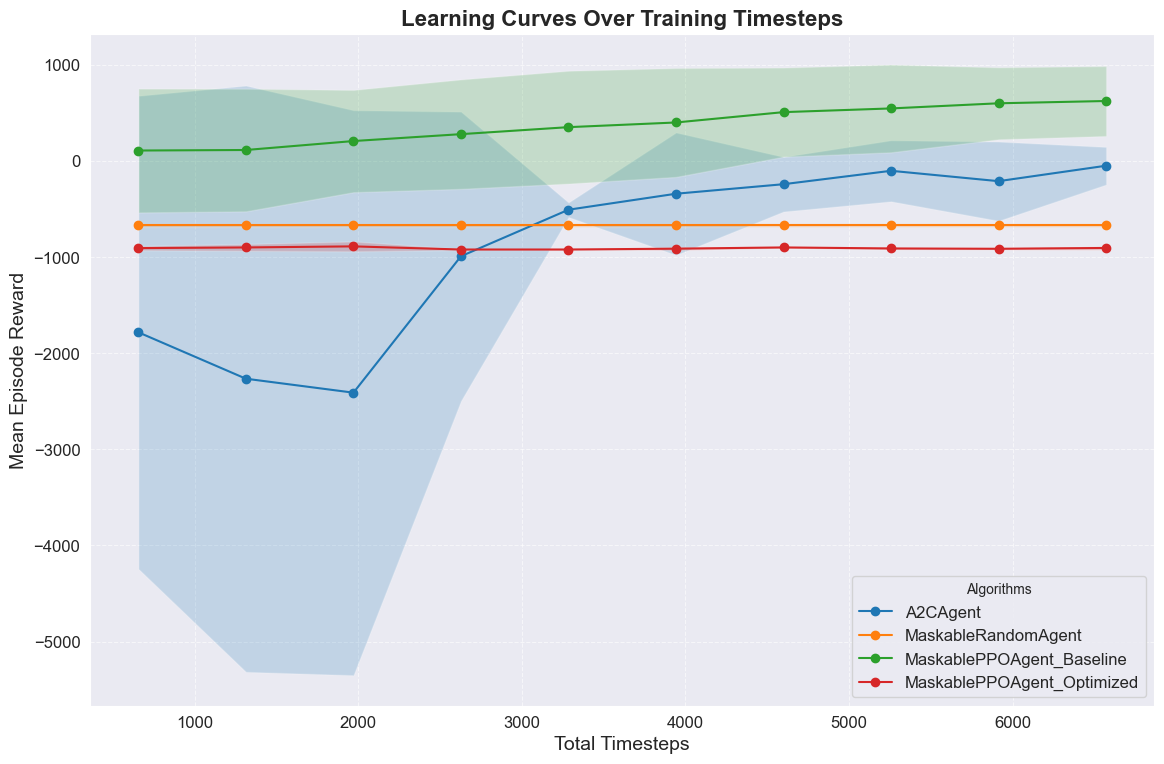

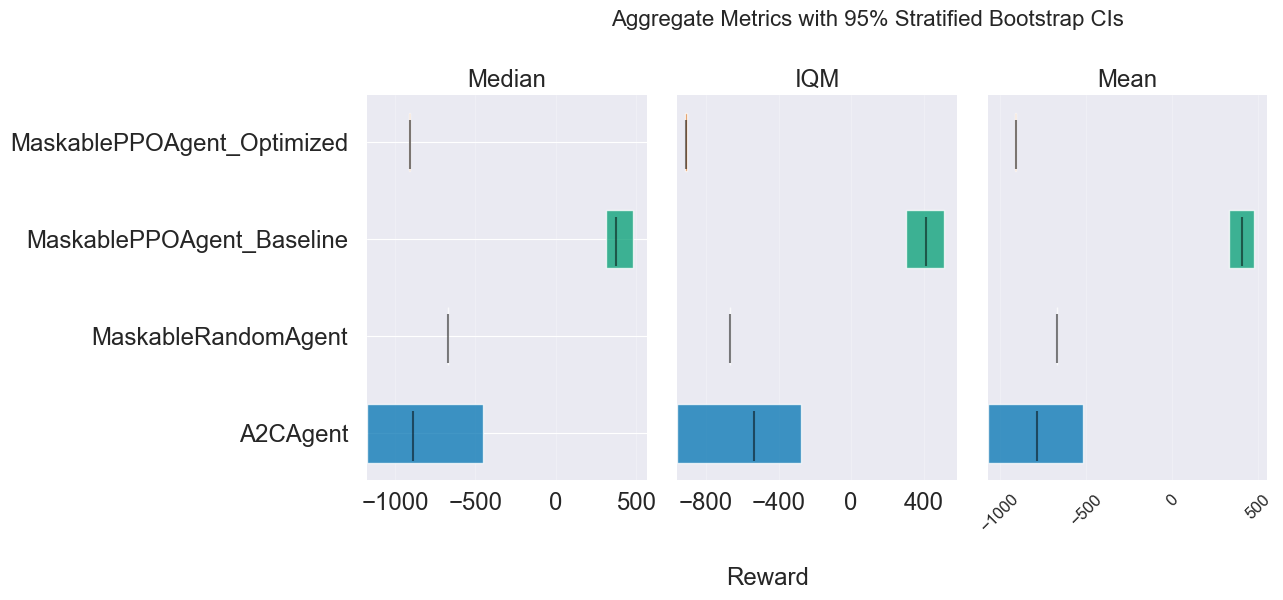

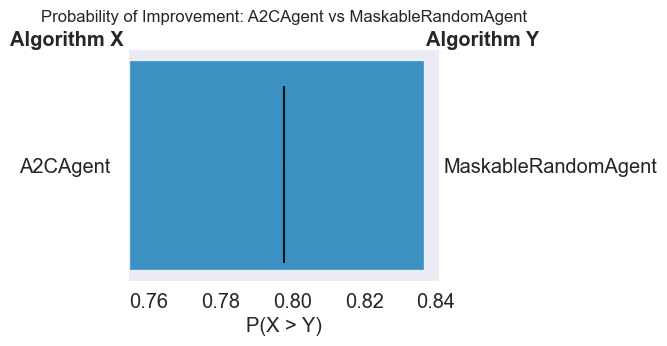

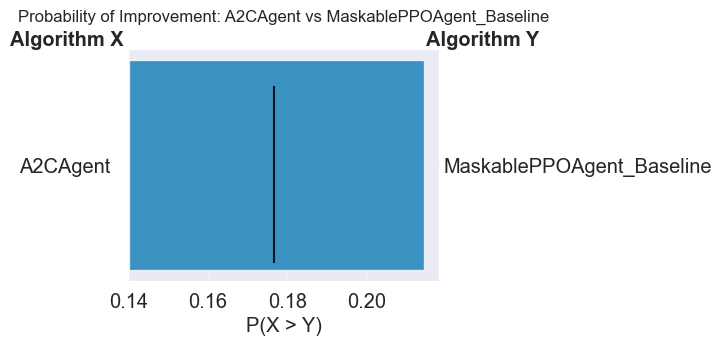

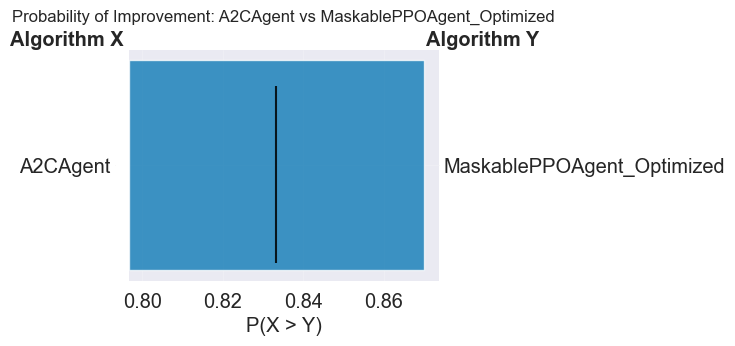

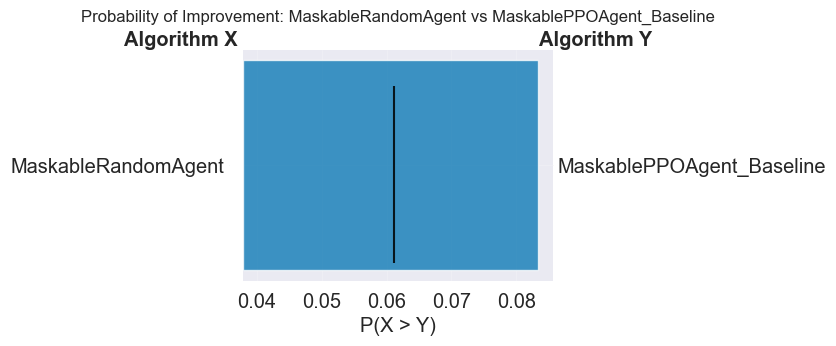

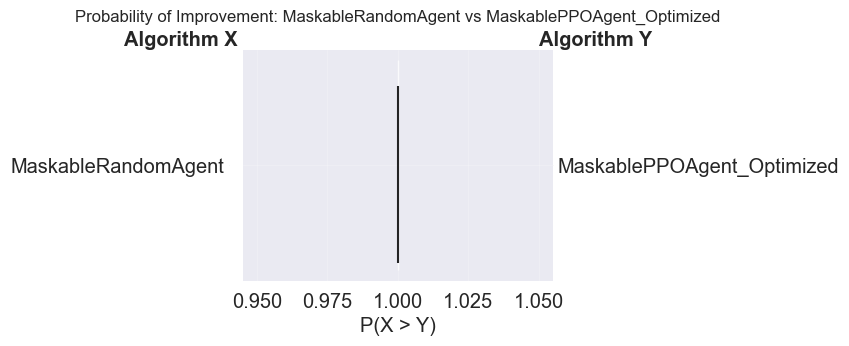

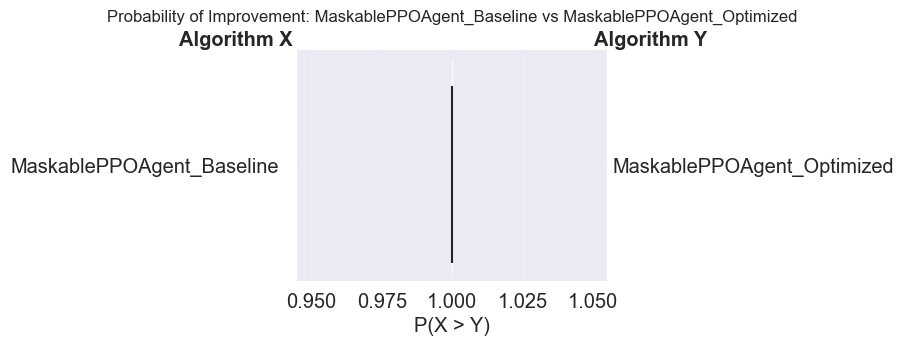

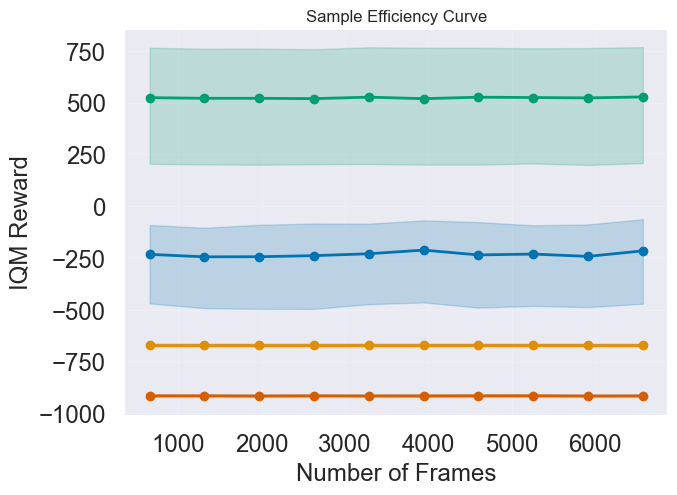

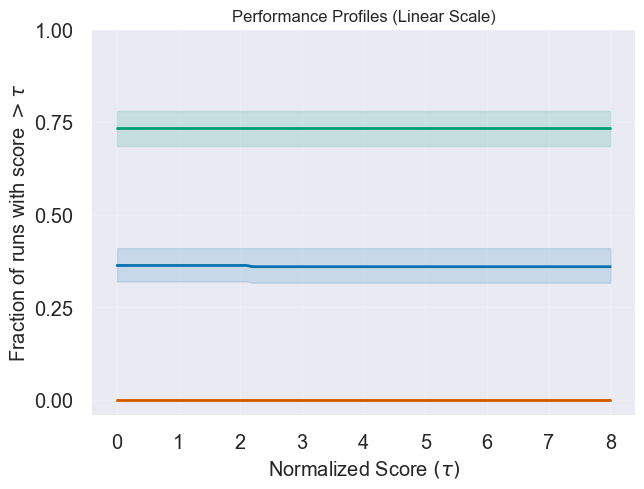

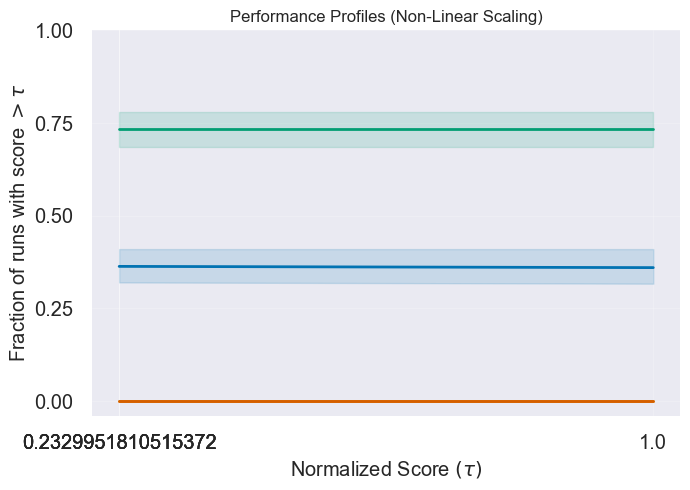

In [ ]:
# | export
plot_evaluation_results(results)

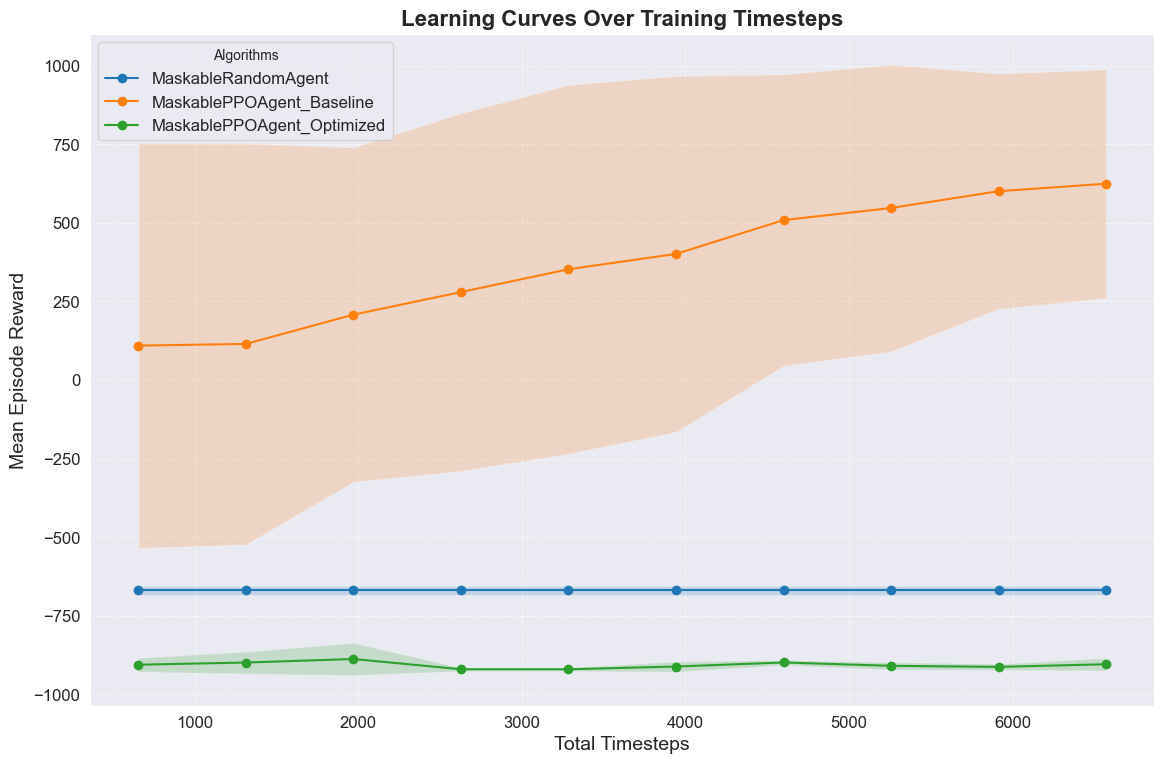

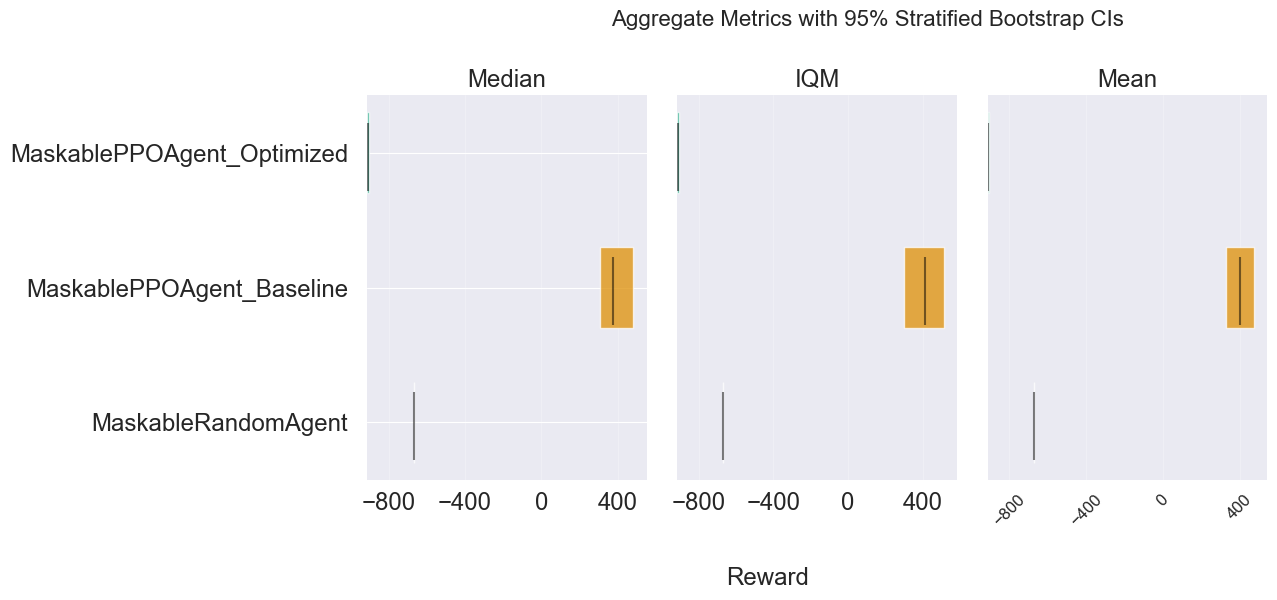

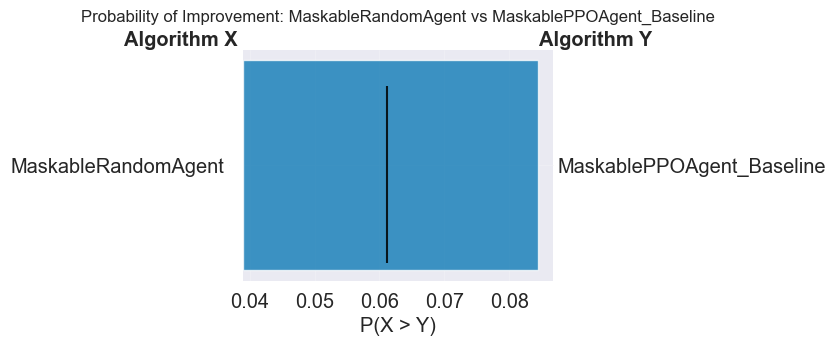

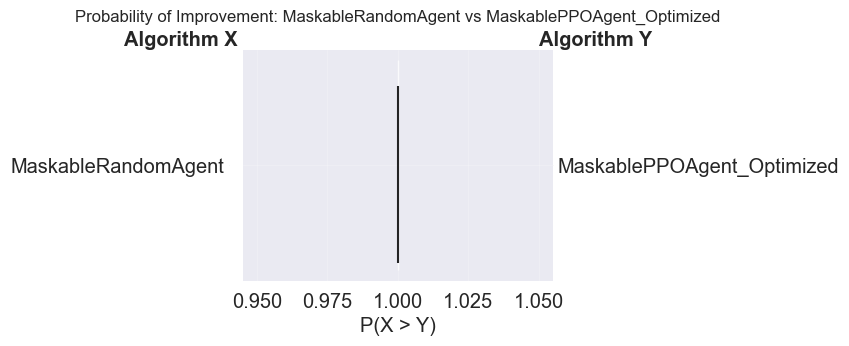

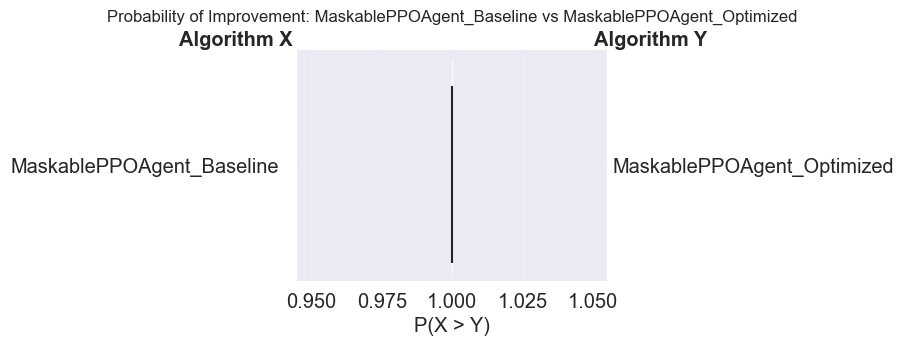

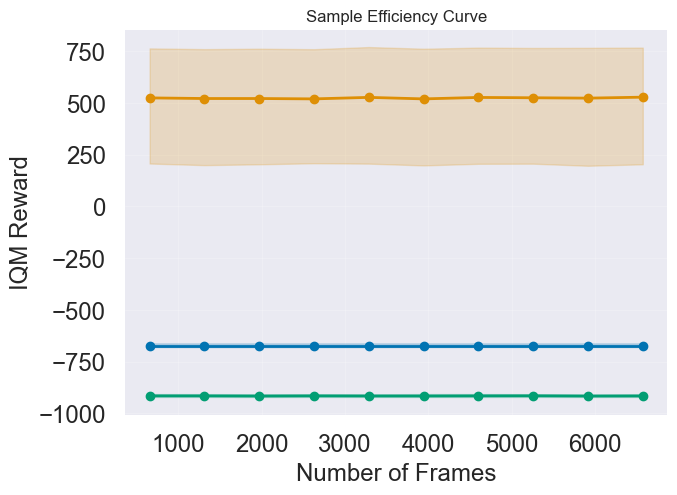

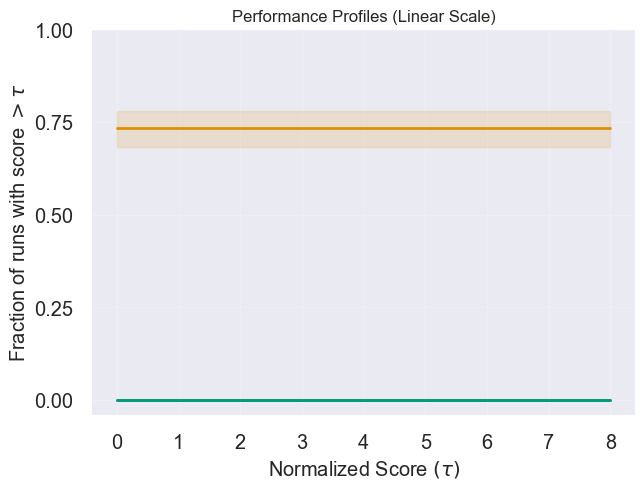

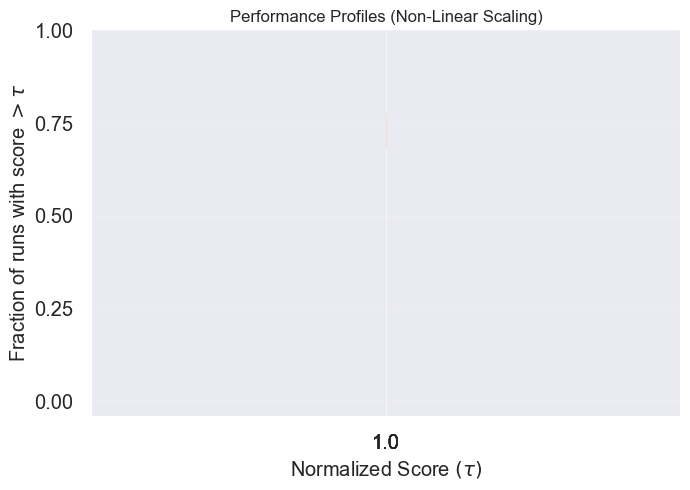

In [ ]:
# | export
results2 = results.copy()
results2.pop("A2CAgent")
plot_evaluation_results(results2)

### Adding expert knowledge to the masking function making learning more efficient

In [ ]:
# | export


def is_action_safe(self, action: int) -> bool:
    target_state_of_charge = self._current_state_of_charge + self.actions[action]
    low, high = self._battery_safe_range
    return high > target_state_of_charge > low


def expert_knowledge_action_masks(self) -> np.ndarray:
    mask = np.array(
        [
            self._is_action_valid(action) and self.is_action_safe(action)
            for action in range(self.action_space.n)
        ],
        dtype=bool,
    )
    if not np.any(mask):  # If all actions are invalid, force one to be valid
        mask[len(mask) // 2] = True
    return mask


# Dynamically overriding action_masks to ElectricityMarketEnv
setattr(ElectricityMarketEnv, "action_masks", expert_knowledge_action_masks)
# Dynamically overriding injection is_action_safe to ElectricityMarketEnv
setattr(ElectricityMarketEnv, "is_action_safe", is_action_safe)

expert_maskable_random_agent = MaskableRandomAgent()
expert_maskable_ppo_agent = MaskablePPOAgent()

In [ ]:
# | export
results["ExpertMaskableRandomAgent"] = expert_maskable_random_agent.evaluate_policy(
    hyperparameters=None, n_episodes=N_EPISODES, render=False
)

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369
   -872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369]
  [-872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369
   -872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369]
  [-872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369
   -872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369]
  [-872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369
   -872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369]
  [-872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369
   -872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369]
  [-872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369
   -872.96669369 -872.96669369 -872.96669369 -872.96669369 -872.96669369]
  [-872.96669369 -872.96669369 -872.96669369 -872.9666936

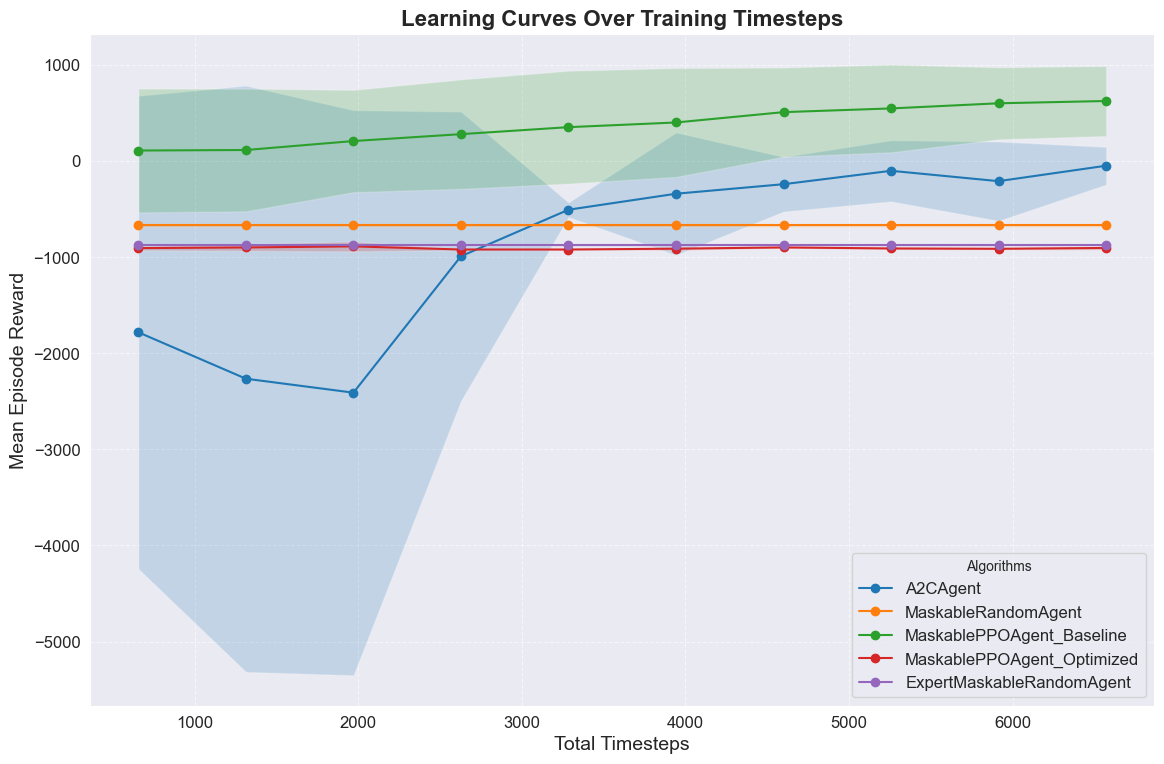

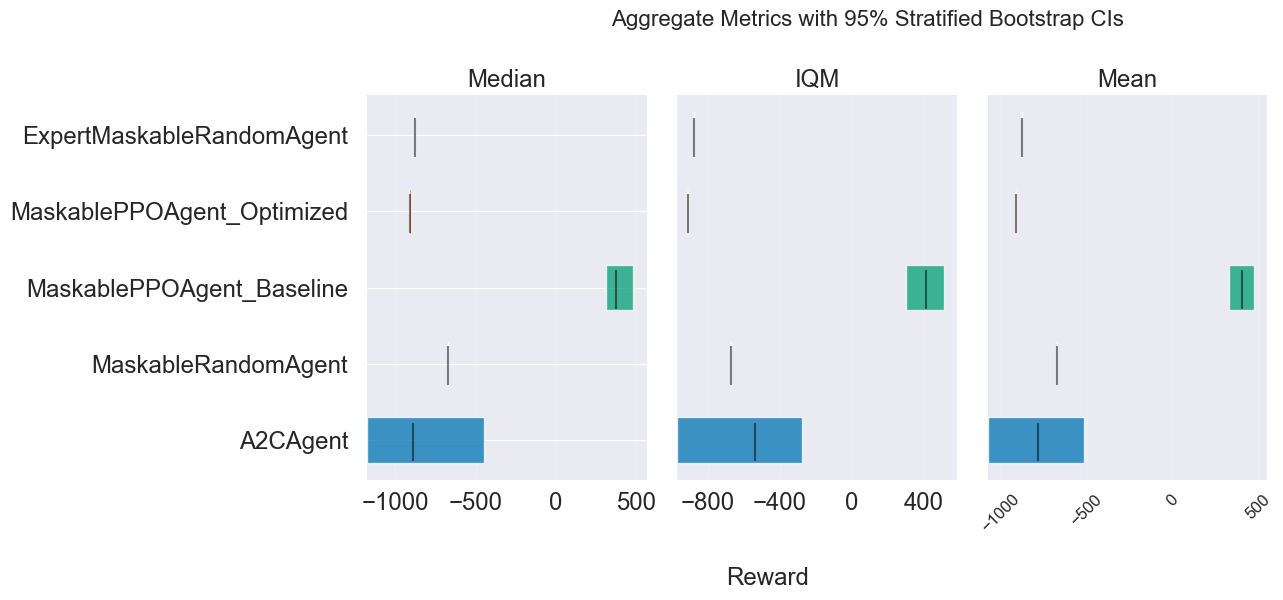

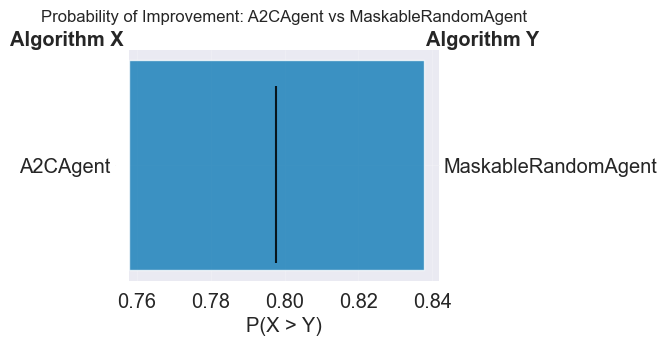

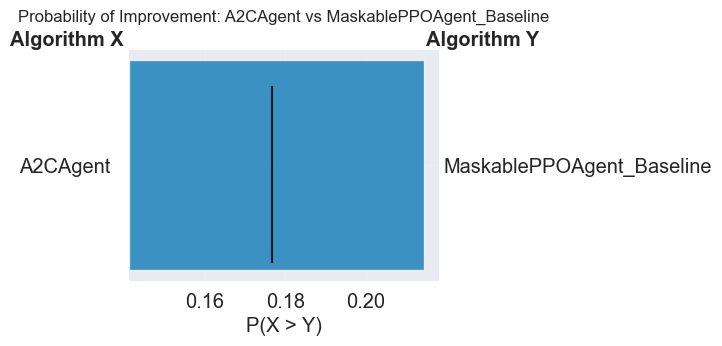

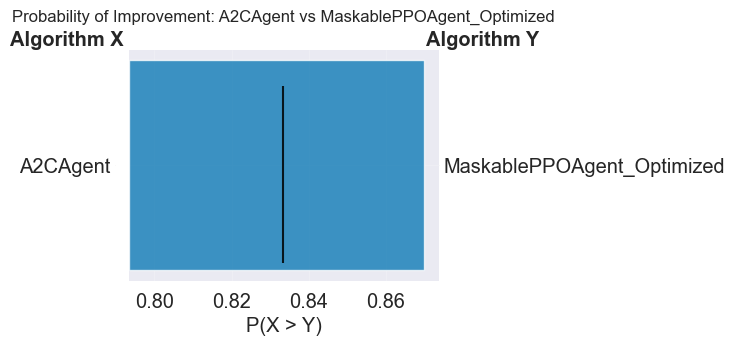

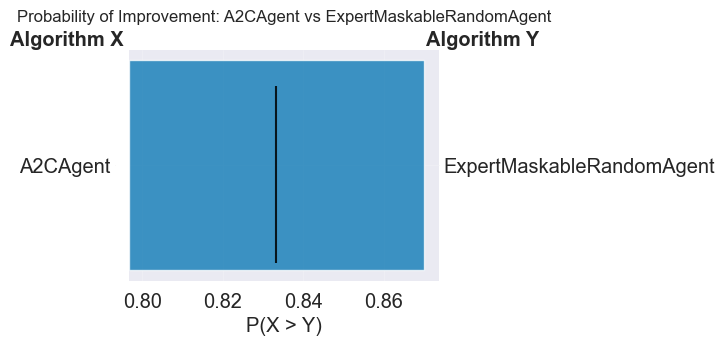

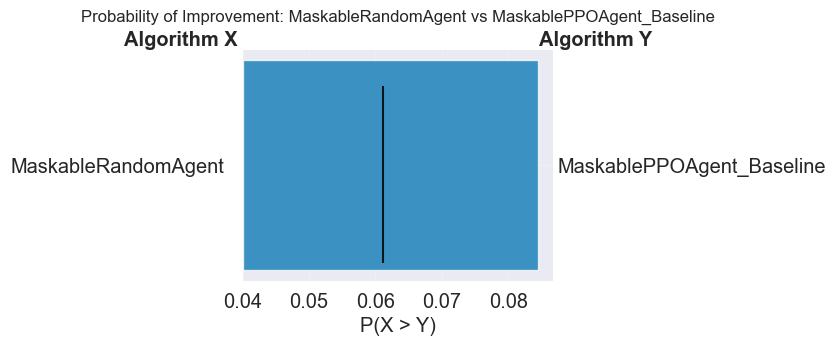

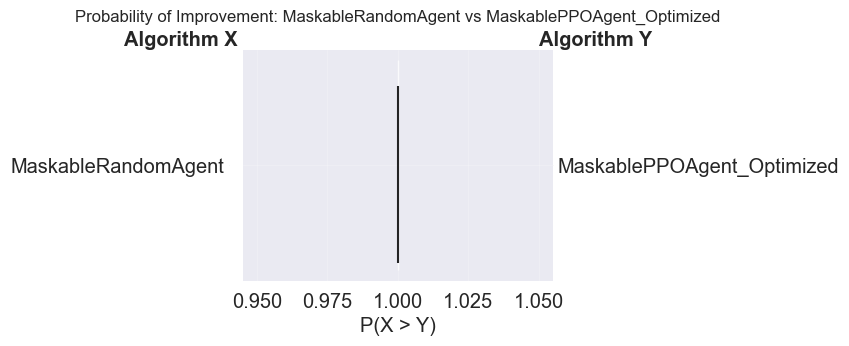

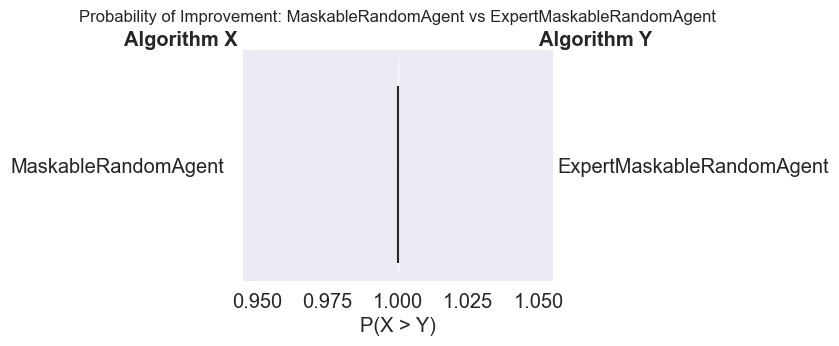

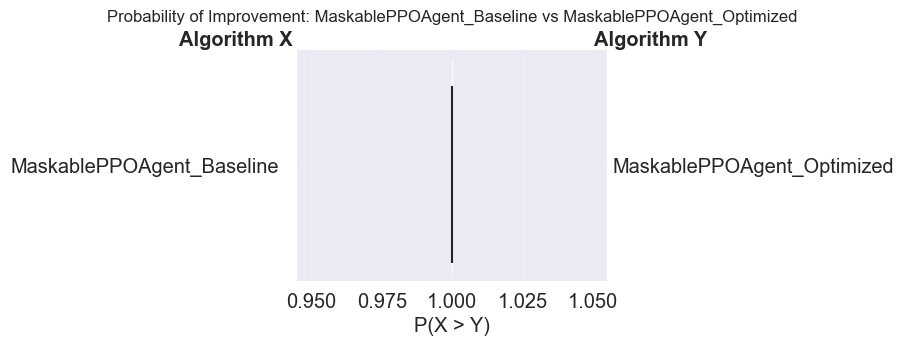

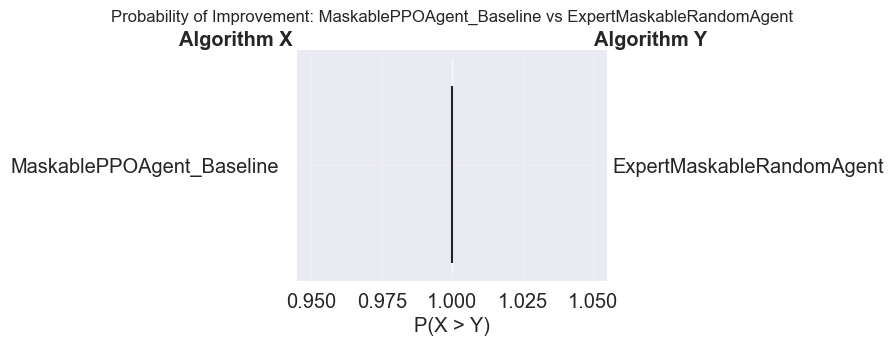

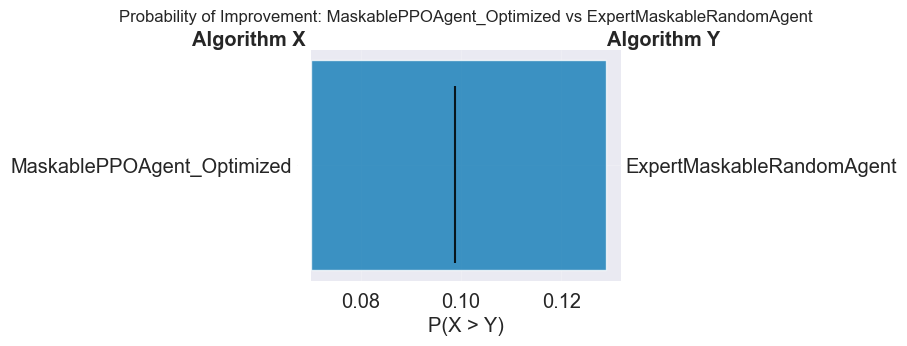

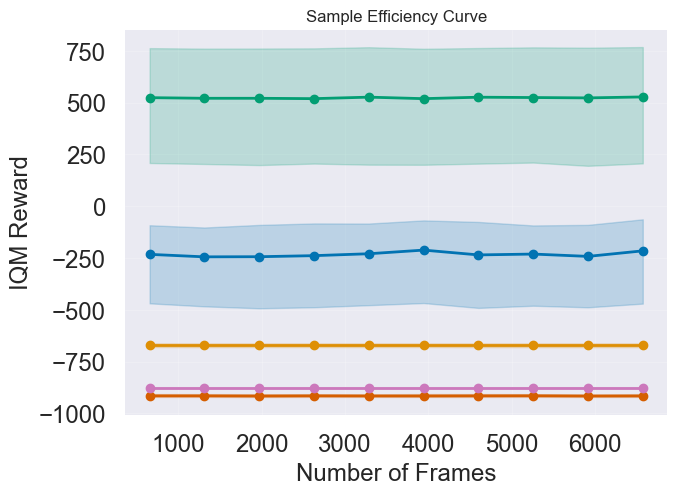

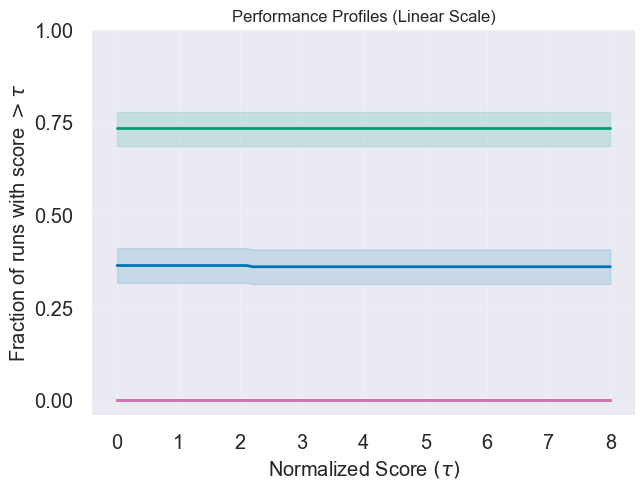

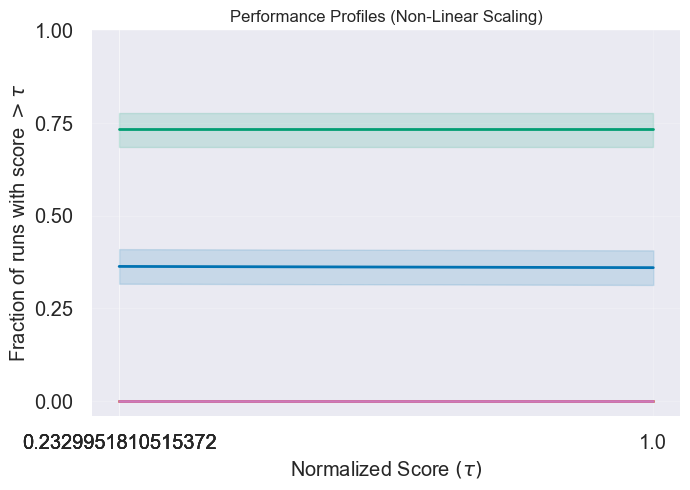

In [ ]:
# | export
plot_evaluation_results(results)

In [ ]:
# | export
results["ExpertMaskablePPOAgent_Baseline"] = expert_maskable_ppo_agent.evaluate_policy(
    hyperparameters=None, n_episodes=N_EPISODES, render=False
)

seeds:   0%|          | 0/3 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]

frames:   0%|          | 0/10 [00:00<?, ?it/s]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-588.771276 -594.719551 -601.302564 -597.315476 -611.827811
   -592.827016 -592.029417 -590.014836 -594.507686 -597.09855 ]
  [-580.373691 -559.927257 -565.573877 -580.024614 -571.956351
   -546.570745 -571.596628 -562.94451  -558.434941 -571.046139]
  [-240.719144 -231.079888 -296.462105 -251.360059 -288.173878
   -295.577095 -246.261829 -285.444156 -278.029933 -243.701443]
  [-287.864856 -305.327439 -293.370865 -265.920053 -303.432204
   -284.801536 -285.835081 -286.037818 -300.069541 -315.117615]
  [-390.768275 -392.80796  -398.30328  -410.718328 -403.164952
   -447.242725 -418.561761 -413.89526  -383.831822 -429.384933]
  [ -88.12281  -119.337027 -130.930103 -134.834703 -120.93671
   -119.638217 -142.37273  -126.843786 -133.048316 -114.153148]
  [-142.760638 -143.963588 -147.804304 -145.27292  -151.175617
   -157.542161 -152.23729  -141.460313 -182.61204  -149.732792]
  [-151.009235 -154.869297 -105.888076 -140.613149 

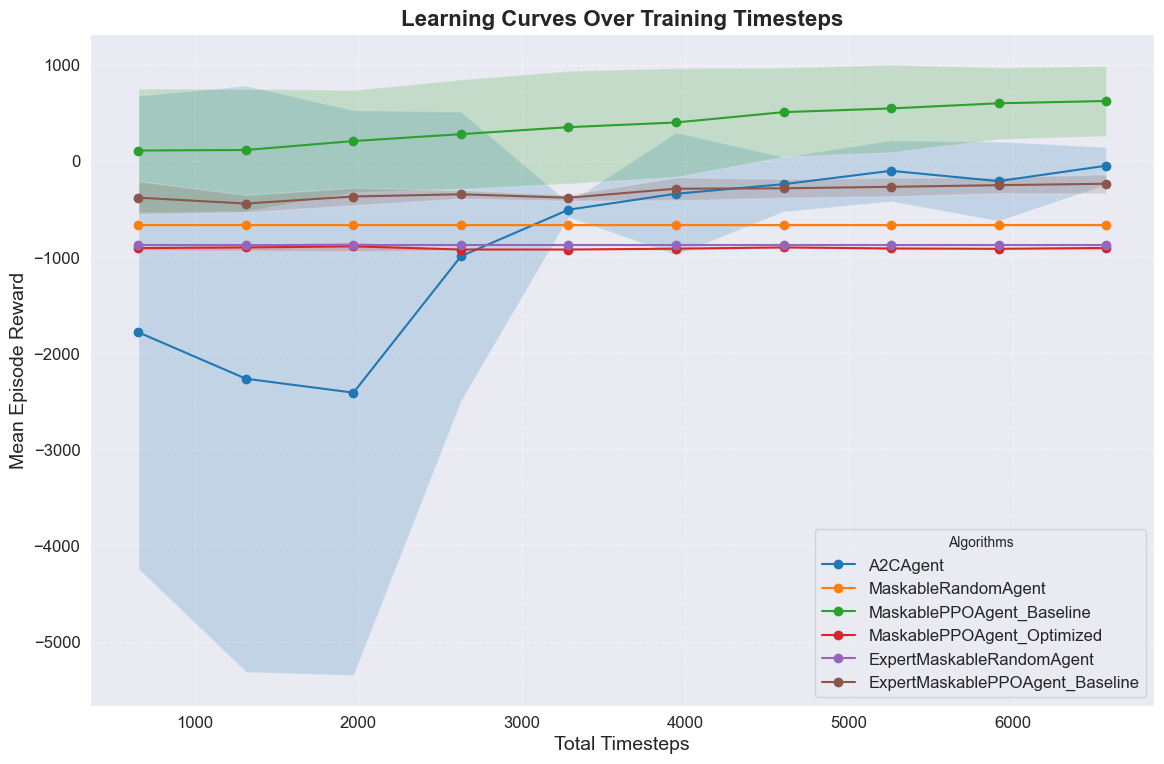

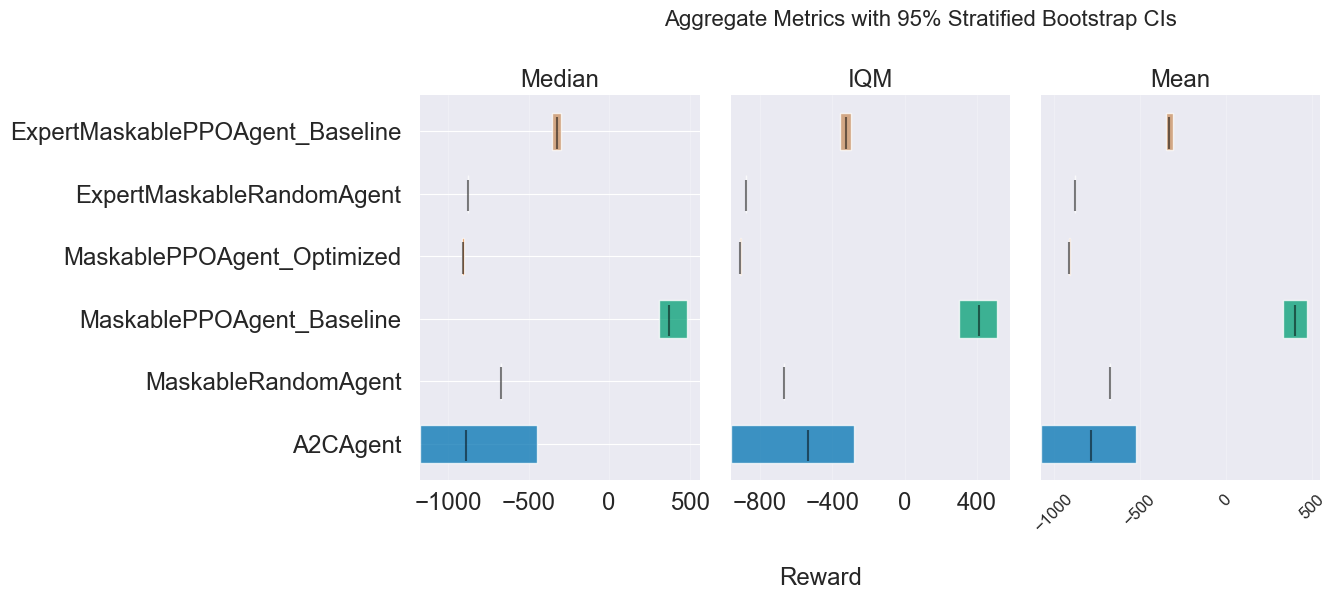

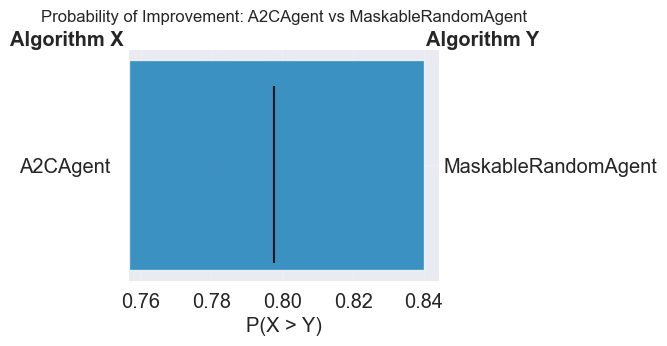

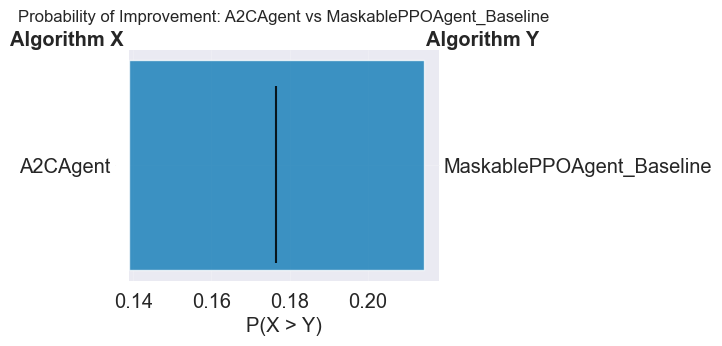

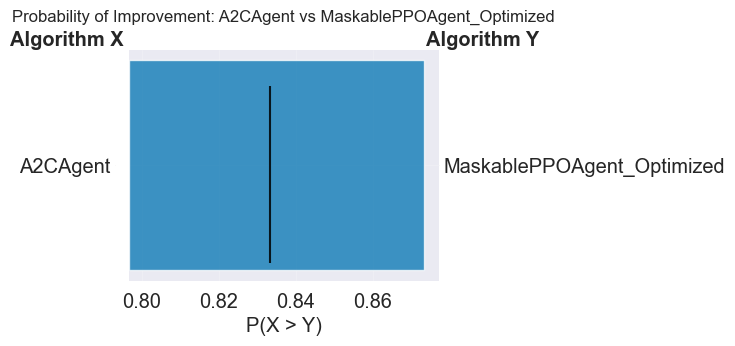

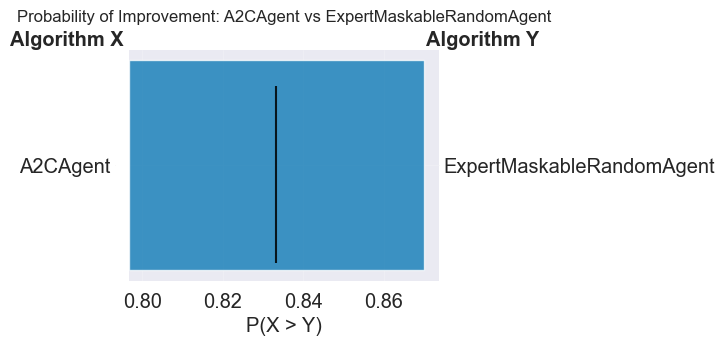

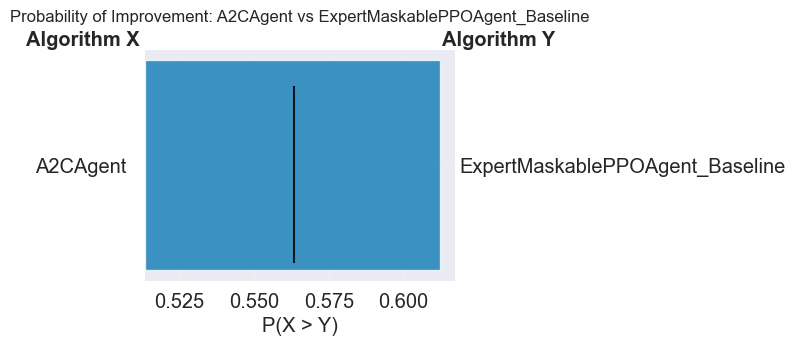

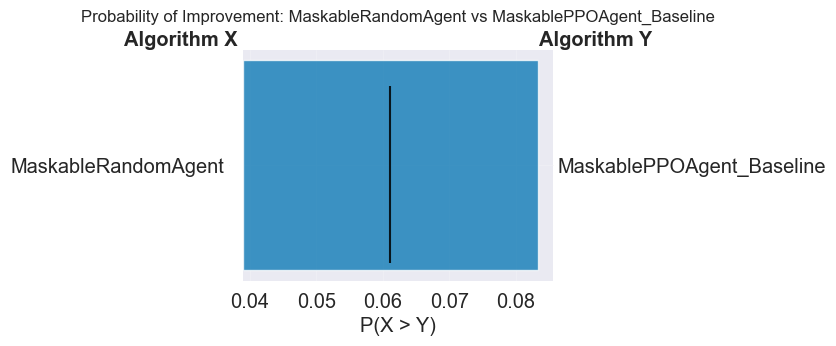

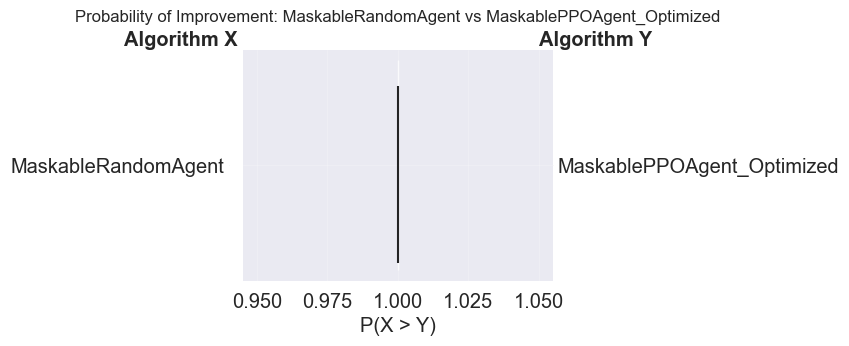

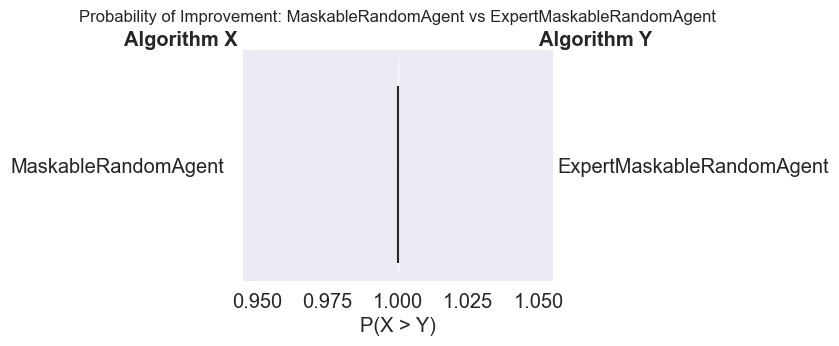

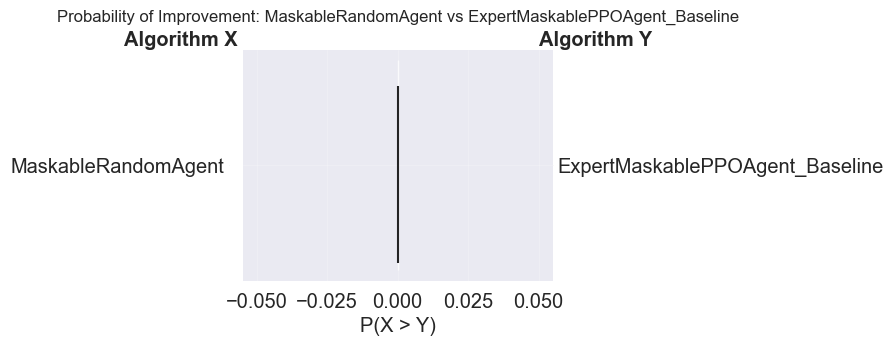

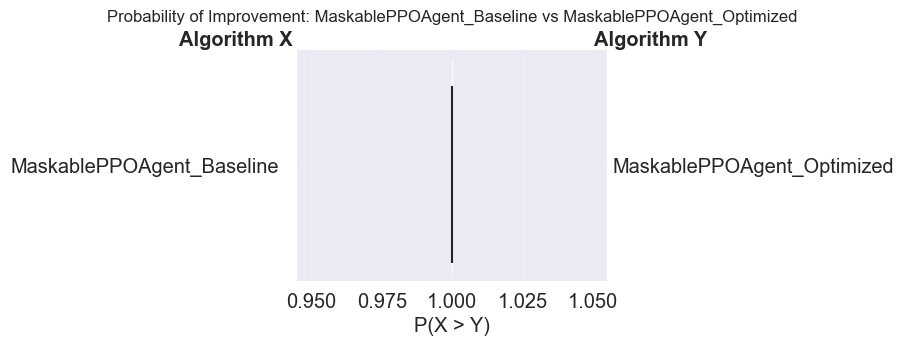

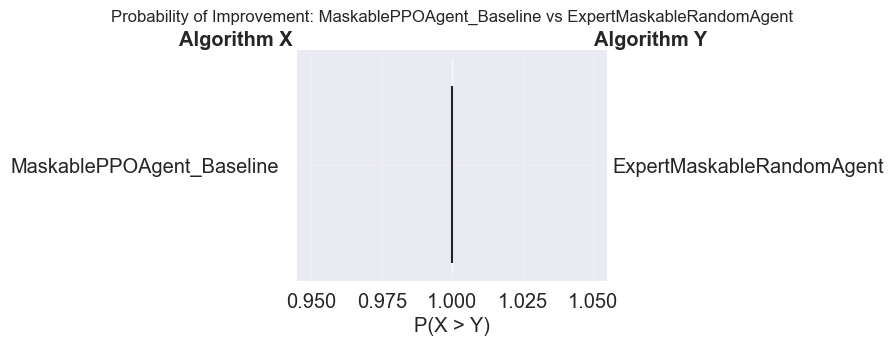

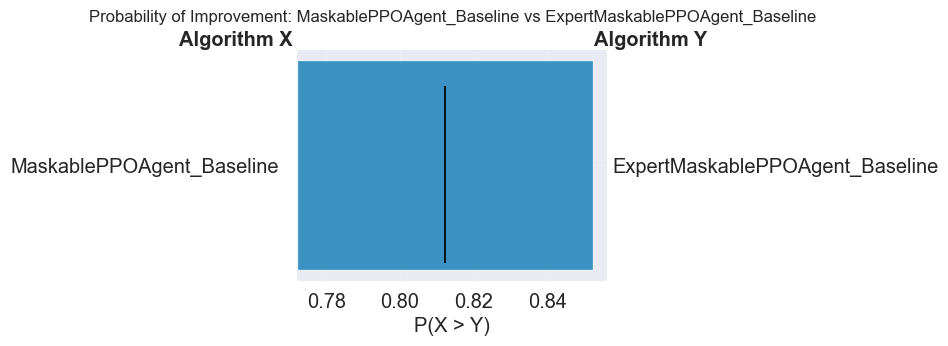

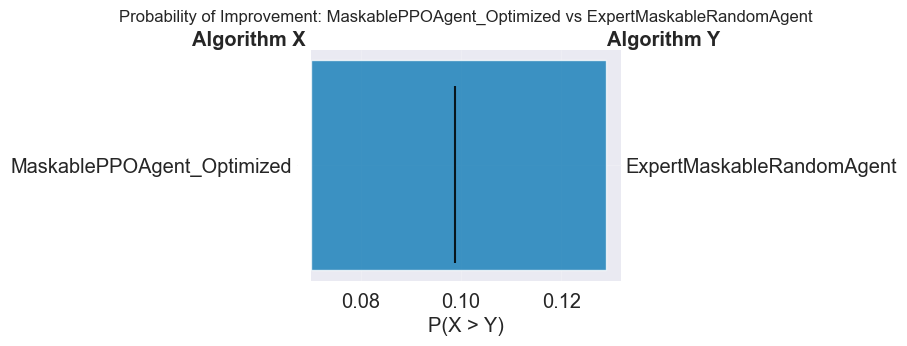

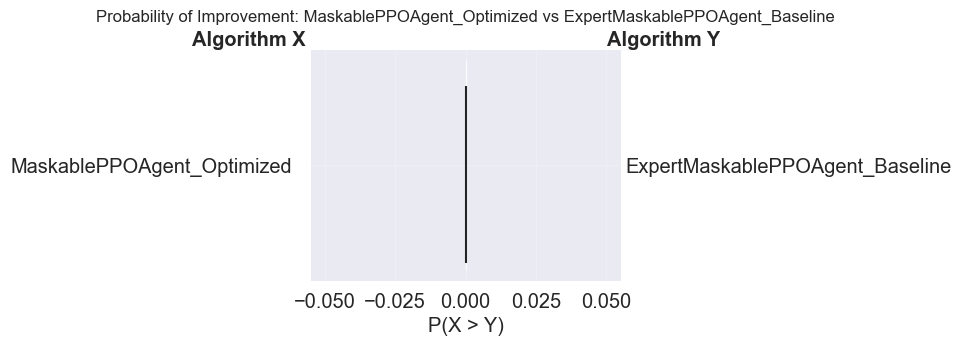

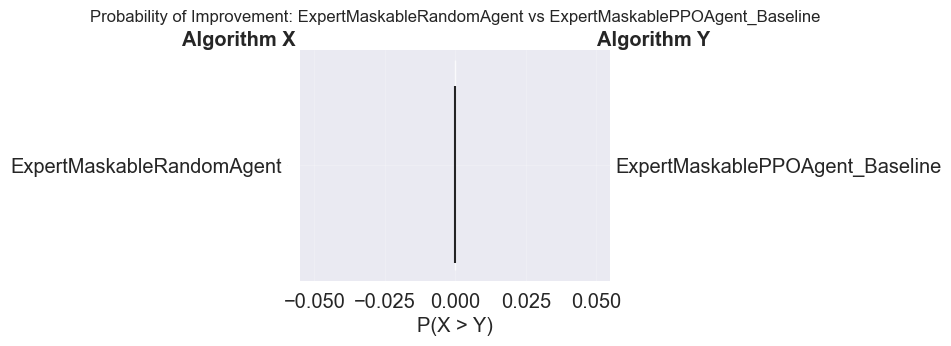

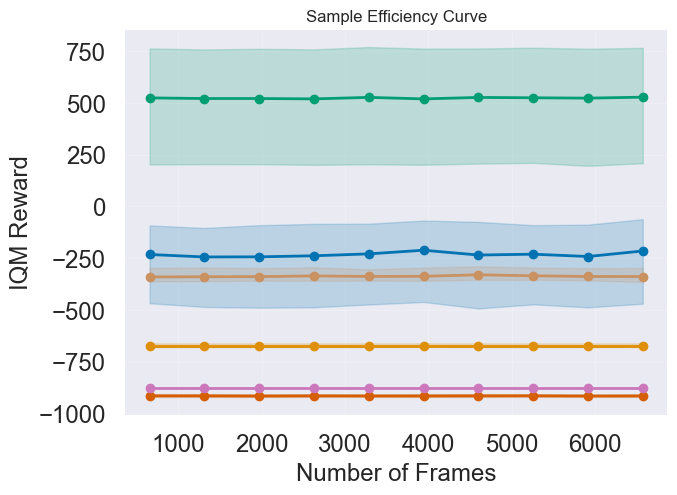

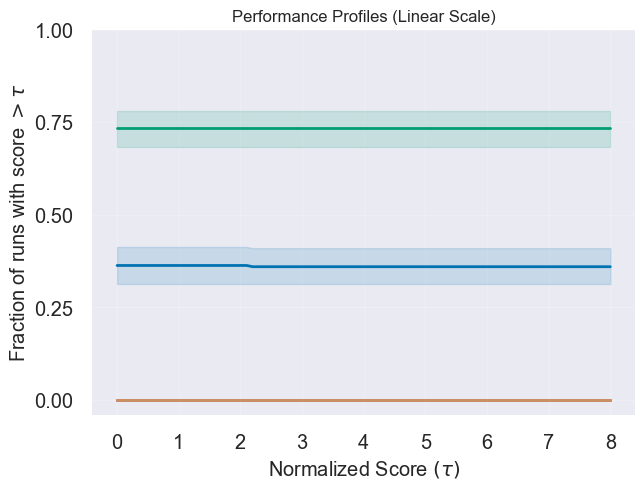

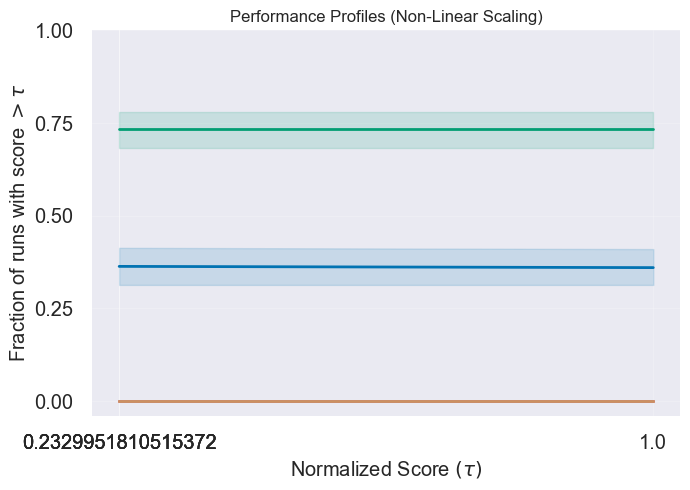

In [ ]:
# | export
plot_evaluation_results(results)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()